In [1]:
import sys
if '..' not in sys.path:
    sys.path.append('..')

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import USPS

import matplotlib.pyplot as plt
import numpy as np

from source.models import AE_ReLU, AE_Sigm
from source.data import get_train_test_dataloaders
from source.eval import eval_loss

from functools import partial
import copy
import math
import gc
from tqdm import tqdm
# from multiprocessing import Pool
import torch.multiprocessing as mp
from collections import OrderedDict

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = 'cpu'

In [5]:
def plot_progress(x, z):
    rows = 2
    cols = 16
    x, z = x[:cols], z[:cols]
    fig, ax = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(cols, rows))
    for i in range(len(x)):
        # ax[i//cols, i%cols].imshow(x[i].cpu().reshape([16, 16]), 'gray')
        # ax[i//cols, i%cols].set_axis_off()
        ax[0, i].imshow(x[i].cpu().reshape([16, 16]), 'gray')
        ax[0, i].set_axis_off()
    for i in range(len(z)):
        # ax[i//cols+2, i%cols].imshow(z[i].detach().cpu().numpy().reshape([16, 16]), 'gray')
        # ax[i//cols+2, i%cols].set_axis_off()
        ax[1, i].imshow(z[i].detach().cpu().numpy().reshape([16, 16]), 'gray')
        ax[1, i].set_axis_off()
    plt.show()

In [6]:
train_loader, test_loader = get_train_test_dataloaders('..', 'USPS', 
                                                       batch_size=7291, 
                                                       drop_last=False,
                                                       num_workers=4)
len(train_loader), len(test_loader)

(1, 1)

In [8]:
model = AE_ReLU(bias=False).to(device)
loss_function = torch.nn.MSELoss()
print('Random-initialized model loss: '
      f'{eval_loss(model, test_loader, loss_function, device=device)}')

Random-initialized model loss: 0.16216500103473663


Random-initialized model reconstruction results:


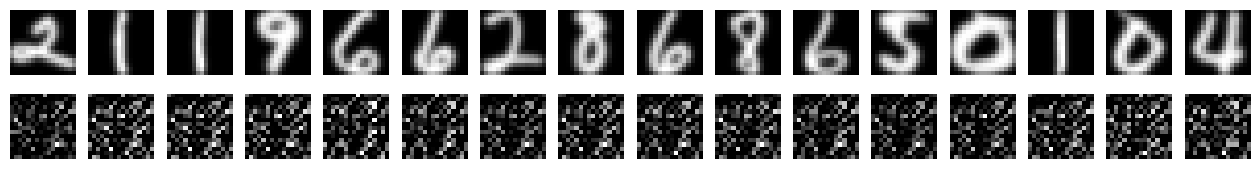

In [9]:
for x, _ in train_loader:
    with torch.no_grad():
        z = model(x)
    
    print('Random-initialized model reconstruction results:')
    plot_progress(x, z)
    
    break

In [10]:
CACHE_OUTPUTS = {}
CACHE_RELUS = {}

def cache_relu_hook(idx, module, input, output):
    CACHE_RELUS[idx] = output.detach().cpu()
    
def cache_output_hook(idx, module, input, output):
    CACHE_OUTPUTS[idx] = output.detach().cpu()

i, j = 0 , 0
relu_handles = []
for m in model.modules():
    if isinstance(m, nn.ReLU):
        handle = m.register_forward_hook(partial(cache_relu_hook, i))
        i += 1
        relu_handles.append(handle)
    # elif isinstance(m, nn.Linear):
    #     handle = m.register_forward_hook(partial(cache_output_hook, j))
    #     j += 1
        
# caching activations
with torch.no_grad():
    for x, _ in train_loader:
        x = x.to(device)
        _ = model(x)
        x = x.cpu()
        
# sizes of cached activattions
for i in range(len(CACHE_RELUS)):
    print(CACHE_RELUS[i].shape)

torch.Size([7291, 300])
torch.Size([7291, 100])
torch.Size([7291, 20])
torch.Size([7291, 100])
torch.Size([7291, 300])
torch.Size([7291, 256])


In [11]:
# removing hooks
for m in model.modules():
    if isinstance(m, nn.ReLU):
        m._forward_hooks = OrderedDict()

0.16216500103473663

In [ ]:
# making sure that the eval loss hasn't changed
eval_loss(model, test_loader, loss_function, device=device)

In [13]:
WEIGHTS = [
    model.encoder[0].weight.detach().cpu(),
    model.encoder[2].weight.detach().cpu(),
    model.encoder[4].weight.detach().cpu(),
    model.decoder[0].weight.detach().cpu(),
    model.decoder[2].weight.detach().cpu(),
    model.decoder[4].weight.detach().cpu(),
]

# sum of all output shapes
H = 0
h_k = [0]
for W in WEIGHTS:
    H += W.shape[0]
    h_k.append(W.shape[0] + h_k[-1])
h_k = h_k[1:]
H, h_k

(1076, [300, 400, 420, 520, 820, 1076])

In [14]:
# simple autoencoder model
model

AE_ReLU(
  (encoder): Sequential(
    (0): Linear(in_features=256, out_features=300, bias=False)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=100, bias=False)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=20, bias=False)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=100, bias=False)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=300, bias=False)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=256, bias=False)
    (5): ReLU()
  )
)

# Gauss-Newton

## gpu, torch, J cut

In [15]:
device = 'cuda'

In [6]:
def calculate_z_residuals(cache_relus, x, h_k, WEIGHTS):
    
    relu = nn.ReLU()
    
    residuals = torch.zeros(h_k[-1])
    start = 0
    for layer_idx in range(len(h_k)):
        if layer_idx == 0:
            residuals[start:h_k[layer_idx]] = cache_relus[start:h_k[layer_idx]] - relu(torch.einsum('q,hq->h', x, WEIGHTS[layer_idx]))
        elif layer_idx == 1:
            residuals[start:h_k[layer_idx]] = cache_relus[start:h_k[layer_idx]] \
                                              - relu(torch.einsum('q,hq->h', cache_relus[:h_k[layer_idx-1]], 
                                                                             WEIGHTS[layer_idx]))
        elif layer_idx == len(h_k) - 1:
            residuals[start:h_k[layer_idx]] = x - relu(torch.einsum('q,hq->h', cache_relus[h_k[layer_idx-2]:h_k[layer_idx-1]], WEIGHTS[layer_idx]))
        else:
            residuals[start:h_k[layer_idx]] = cache_relus[start:h_k[layer_idx]] \
                                              - relu(torch.einsum('q,hq->h', cache_relus[h_k[layer_idx-2]:h_k[layer_idx-1]], 
                                                                             WEIGHTS[layer_idx]))
        start = h_k[layer_idx]
    return residuals

def z_step(n_sample, cache_relus, x, WEIGHTS, mu, h_k):
    
    # Calculating Residuals
    residuals = calculate_z_residuals(cache_relus, x, h_k, WEIGHTS)
    
    # Quadratic Penalty
    assert len(residuals) == h_k[-1]
    # Quadratic Penalty
    mu_mult = torch.ones_like(residuals)
    mu_mult[:h_k[-2]] = math.sqrt(mu)
    residuals = mu_mult * residuals

    # Building Jacobian for each sample in dataset
    J = torch.zeros((h_k[-1], h_k[-2]))
    for h in range(h_k[-1]):
        if h < h_k[-2]: J[h, h] = mu
        for layer_idx in range(len(h_k)):
            if h < h_k[layer_idx]: break
        if layer_idx == 0: continue

        n_feature = h-h_k[layer_idx-1]
        assert n_feature >= 0 and n_feature < WEIGHTS[layer_idx].shape[0]

        if layer_idx == 1:
            start, finish = 0, h_k[layer_idx-1]
        elif layer_idx > 1:
            start, finish = h_k[layer_idx-2], h_k[layer_idx-1]
        if cache_relus[h] > 0:
            J[h, start:finish] = - WEIGHTS[layer_idx][n_feature]
            # Quadratic Penalty
            if layer_idx != len(h_k)-1:
                J[h, start:finish] *= mu

    # Descent Direction
    p = torch.linalg.lstsq(J.T@J, - J.T @ residuals, rcond=None)[0]
    # p.T @ grad (.T doesn't matter, numpy performs inner product)
    descent_inner_prod = (J.T @ residuals) @ p
    try:
        assert descent_inner_prod <= 0
    except:
        print(f'sample {n_sample} descent direction should be <= 0', descent_inner_prod)

    # Line Search with Backtracking
    p_ = torch.zeros(h_k[-1])
    p_[:h_k[-2]] = p
    alpha = 1.0
    fw = residuals.sum() / 2
    # recompute residuals with relus update
    residuals_new = calculate_z_residuals(cache_relus + alpha * p_, x, h_k, WEIGHTS)

    # Quadratic Penalty
    residuals_new = mu_mult * residuals_new
    fw_new = (residuals_new**2).sum() / 2
    rhs = alpha * line_search_c * descent_inner_prod

    max_iter, counter = 40, 0
    # Armijo Condition
    while fw_new - fw > rhs and counter < max_iter:
        # step update
        alpha *= line_search_tau

        # recompute residuals with new relus update
        residuals_new = calculate_z_residuals(cache_relus + alpha * p_, x, h_k, WEIGHTS)

        # Quadratic Penalty
        residuals_new = mu_mult * residuals_new
        fw_new = (residuals_new**2).sum() / 2
        rhs = alpha * line_search_c * descent_inner_prod

        # print("Line search armijo: obj func old: %f new: %f diff: %.16f rhs: %.16f, alpha: %f" % (fw, fw_new, fw_new - fw, rhs, alpha))
        counter += 1
     
    return J, cache_relus + alpha * p_

In [7]:
def calculate_w_residuals(layer_idx, h, w_h, x, CACHE_RELUS):
    
    relu = nn.ReLU()
    
    if layer_idx == 0:
        residuals = CACHE_RELUS[layer_idx][:,h] - relu(torch.einsum('bq,q->b', x, w_h))
    elif layer_idx == len(CACHE_RELUS) - 1:
        residuals = x[:,h] - relu(torch.einsum('bq,q->b', CACHE_RELUS[layer_idx-1], w_h))
    else:
        residuals = CACHE_RELUS[layer_idx][:,h] - relu(torch.einsum('bq,q->b', CACHE_RELUS[layer_idx-1], w_h))
        
    return residuals

def w_step(layer_idx, h, w_h, x, CACHE_RELUS, n_samples):
    residuals = calculate_w_residuals(layer_idx, h, w_h, x, CACHE_RELUS)
    
    # Building Jacobian (for each layer and output dim)
    J = torch.zeros((n_samples, len(w_h)))

    if layer_idx == 0:
        for n in range(n_samples):
            if CACHE_RELUS[layer_idx][n][h] > 0:
                J[n, :] = - x[n]
    else:
        for n in range(n_samples):
            if CACHE_RELUS[layer_idx][n][h] > 0:
                J[n, :] = - CACHE_RELUS[layer_idx-1][n]

    # why not inversion here?
    p = torch.linalg.lstsq(J.T@J, - J.T @ residuals, rcond=None)[0]
    # p.T @ grad (.T doesn't matter, numpy performs inner product)
    descent_inner_prod = (J.T @ residuals) @ p
    try:
        assert descent_inner_prod <= 0
    except:
        # pass
        print(f'layer {layer_idx+1} dim {h} descent(should be <= 0)', descent_inner_prod)

    # Line Search with Backtracking
    alpha = 1.0
    fw = (residuals**2).sum() / 2
    # First Update
    residuals_new = calculate_w_residuals(layer_idx, h, w_h + alpha*p, x, CACHE_RELUS)
    fw_new = (residuals_new**2).sum() / 2
    rhs = alpha * line_search_c * descent_inner_prod

    max_iter, counter = 40, 0
    # Armijo Condition
    while fw_new - fw > rhs and counter < max_iter:
        alpha *= line_search_tau
        # Update
        residuals_new = calculate_w_residuals(layer_idx, h, w_h + alpha*p, x, CACHE_RELUS)
        fw_new = (residuals_new**2).sum() / 2
        rhs = alpha * line_search_c * descent_inner_prod

        # print("Line search armijo: obj func old: %f new: %f diff: %.16f rhs: %.16f, alpha: %f" % (fw, fw_new, fw_new - fw, rhs, alpha))
        counter += 1
        
    return w_h + alpha*p

In [8]:
%%time

relu = nn.ReLU()

line_search_c = pow(10,-4)
# backtracking multiplier
line_search_tau = 0.5

# Quadratic Penalty multiplier 
mu = 1.0

loss_function = torch.nn.MSELoss()
loss_hist = []

# creating model
model = AE().to(device)
loss = eval_loss(model, test_loader, loss_function, device=device)
loss_hist.append(loss)
print(f'Random-initialized model loss: {loss}')

WEIGHTS = [
    model.encoder[0].weight.detach().cpu(),
    model.encoder[2].weight.detach().cpu(),
    model.encoder[4].weight.detach().cpu(),
    model.decoder[0].weight.detach().cpu(),
    model.decoder[2].weight.detach().cpu(),
    model.decoder[4].weight.detach().cpu(),
]

# all output shapes
h_k = [0]
for W in WEIGHTS:
    h_k.append(W.shape[0] + h_k[-1])
h_k = h_k[1:]

# registering hooks to cache activations
CACHE_RELUS = {}

def cache_relu_hook(idx, module, input, output):
    CACHE_RELUS[idx] = output.detach().cpu()

i = 0 
for m in model.modules():
    if isinstance(m, nn.ReLU):
        handle = m.register_forward_hook(partial(cache_relu_hook, i))
        i += 1
        
# caching activations
with torch.no_grad():
    for x, _ in train_loader:
        x = x.to(device)
        _ = model(x)
        x = x.detach().cpu()
        
# Removing Hooks
for m in model.modules():
    if isinstance(m, nn.ReLU):
        m._forward_hooks = OrderedDict()
        
def _get_n_sample_relus(n_sample, cache):
    n_sample_relus = torch.zeros(h_k[-1])
    start = 0
    for layer_idx in range(len(h_k)):
        n_sample_relus[start:h_k[layer_idx]] = cache[layer_idx][n_sample]
        start = h_k[layer_idx]
    return n_sample_relus

n_samples = x.shape[0]
print('n samples:', n_samples)
        
with torch.no_grad():
    for epoch in range(10):
        
        # W-Step
        WEIGHTS_COPY = copy.deepcopy(WEIGHTS)

        for layer_idx in tqdm(range(len(h_k))):

            for h in range(WEIGHTS[layer_idx].shape[0]):
            # for h in range(10):
                it = 1
                while True:
                    w_h = WEIGHTS[layer_idx][h]
                    new_w_h = w_step(layer_idx, h, w_h, x, CACHE_RELUS, n_samples)
                    rel_diff = torch.linalg.norm(new_w_h-w_h) / torch.linalg.norm(w_h)
                    # print(f'layer_idx {layer_idx}, h: {h}, it: {it}, REL_DIFF: {rel_diff}')
                    if rel_diff < 5:
                        # print(f'layer_idx {layer_idx}, h: {h}, it: {it}, REL_DIFF: {rel_diff}')
                        break
                    it += 1
                    WEIGHTS[layer_idx][h] = new_w_h
                    
        # Checking Norm Difference
        for layer_idx in range(len(h_k)):
            print(f'Layer {layer_idx}, '
                  f'Weights Diff Norm (%): {torch.linalg.norm(WEIGHTS[layer_idx]-WEIGHTS_COPY[layer_idx]) / torch.linalg.norm(WEIGHTS_COPY[layer_idx])}')
        
        # Loading weights back to model to compute eval loss
        model.encoder[0].weight.data = WEIGHTS[0]
        model.encoder[2].weight.data = WEIGHTS[1]
        model.encoder[4].weight.data = WEIGHTS[2]
        model.decoder[0].weight.data = WEIGHTS[3]
        model.decoder[2].weight.data = WEIGHTS[4]
        model.decoder[4].weight.data = WEIGHTS[5]
        model = model.to(device)
        
        # Loss on eval dataset
        loss = eval_loss(model, test_loader, loss_function, device=device)
        loss_hist.append(loss)
        print(f'Epoch {epoch+1}, Eval loss: {loss}')
        
        # Updating Quandratic Penalty Multiplier
        if abs(loss_hist[-2] - loss_hist[-1]) < 1e-2:
            mu *= 10
            print(f'New MU: {mu}')
        
        # # recalculating activations after weights update
        # for x, _ in train_loader:
        #     x = x.to(device)
        #     _ = model(x)
        #     x = x.cpu()
    
        # Z-Step
        CACHE_RELUS_COPY = copy.deepcopy(CACHE_RELUS)
        
        # process for each sample
        for n_sample in tqdm(range(n_samples)):
        # for n_sample in tqdm(range(10)):
            it = 1
            while True:
                relus = _get_n_sample_relus(n_sample, CACHE_RELUS)
                J, new_relus = z_step(n_sample, relus, x[n_sample], WEIGHTS, mu, h_k)
                start = 0
                for layer_idx in range(len(h_k)):
                    CACHE_RELUS[layer_idx][n_sample] = new_relus[start:h_k[layer_idx]]
                    start = h_k[layer_idx]
                    
                rel_diff = torch.linalg.norm(new_relus - relus) / torch.linalg.norm(relus)

                # diff less than 5%
                if rel_diff < 0.05:
                    # print(f'n sample: {n_sample}, it: {it}, REL_DIFF: {rel_diff}')
                    break
                it += 1

        # Computing Relus Norm Difference
        for layer_idx in range(len(CACHE_RELUS)):
            print(f'Layer {layer_idx} Activations Diff Norm (%): '
                  f'{torch.linalg.norm(CACHE_RELUS[layer_idx]-CACHE_RELUS_COPY[layer_idx]) / torch.linalg.norm(CACHE_RELUS_COPY[layer_idx])}')
           
        # print()

Random-initialized model loss: 0.16204164922237396
n samples: 7291


 83%|████████▎ | 5/6 [01:27<00:18, 18.68s/it]

layer 6 dim 35 descent(should be <= 0) tensor(3.0883e-05)
layer 6 dim 38 descent(should be <= 0) tensor(7.3110e-05)
layer 6 dim 67 descent(should be <= 0) tensor(0.0003)
layer 6 dim 68 descent(should be <= 0) tensor(0.0266)
layer 6 dim 167 descent(should be <= 0) tensor(0.0821)
layer 6 dim 170 descent(should be <= 0) tensor(0.0029)
layer 6 dim 193 descent(should be <= 0) tensor(3.5866e-06)
layer 6 dim 199 descent(should be <= 0) tensor(3.2047e-08)
layer 6 dim 202 descent(should be <= 0) tensor(8.7764e-08)
layer 6 dim 203 descent(should be <= 0) tensor(0.1334)
layer 6 dim 219 descent(should be <= 0) tensor(1.3836e-08)
layer 6 dim 228 descent(should be <= 0) tensor(6.6775e-05)
layer 6 dim 229 descent(should be <= 0) tensor(0.0092)


100%|██████████| 6/6 [02:16<00:00, 22.69s/it]

Layer 0, Weights Diff Norm (%): 0.0
Layer 1, Weights Diff Norm (%): 0.0
Layer 2, Weights Diff Norm (%): 0.0
Layer 3, Weights Diff Norm (%): 0.0
Layer 4, Weights Diff Norm (%): 0.0
Layer 5, Weights Diff Norm (%): 22.883180618286133


Epoch 1, Eval loss: 0.08307775855064392


100%|██████████| 7291/7291 [09:22<00:00, 12.97it/s]


Layer 0 Activations Diff Norm (%): 0.002363574458286166
Layer 1 Activations Diff Norm (%): 0.02545028366148472
Layer 2 Activations Diff Norm (%): 0.4390753507614136
Layer 3 Activations Diff Norm (%): 1.740473747253418
Layer 4 Activations Diff Norm (%): 7.116365909576416
Layer 5 Activations Diff Norm (%): 0.0


100%|██████████| 6/6 [02:10<00:00, 21.76s/it]

Layer 0, Weights Diff Norm (%): 0.0
Layer 1, Weights Diff Norm (%): 0.0
Layer 2, Weights Diff Norm (%): 0.0
Layer 3, Weights Diff Norm (%): 0.0
Layer 4, Weights Diff Norm (%): 0.0
Layer 5, Weights Diff Norm (%): 0.5757526159286499


Epoch 2, Eval loss: 0.0736522227525711
New MU: 10.0


100%|██████████| 7291/7291 [06:47<00:00, 17.88it/s]


Layer 0 Activations Diff Norm (%): 4.603633068052187e-16
Layer 1 Activations Diff Norm (%): 4.364928489724966e-15
Layer 2 Activations Diff Norm (%): 4.569605869912674e-14
Layer 3 Activations Diff Norm (%): 5.248219190506255e-14
Layer 4 Activations Diff Norm (%): 3.229284989913171e-14
Layer 5 Activations Diff Norm (%): 0.0


 83%|████████▎ | 5/6 [01:38<00:20, 20.63s/it]

layer 6 dim 35 descent(should be <= 0) tensor(0.0003)


100%|██████████| 6/6 [02:06<00:00, 21.06s/it]

Layer 0, Weights Diff Norm (%): 0.0
Layer 1, Weights Diff Norm (%): 0.0
Layer 2, Weights Diff Norm (%): 0.0
Layer 3, Weights Diff Norm (%): 0.0
Layer 4, Weights Diff Norm (%): 0.0
Layer 5, Weights Diff Norm (%): 0.014261732809245586


Epoch 3, Eval loss: 0.0736452266573906
New MU: 100.0


100%|██████████| 7291/7291 [06:50<00:00, 17.76it/s]


Layer 0 Activations Diff Norm (%): 1.215304873270341e-16
Layer 1 Activations Diff Norm (%): 1.1238405615599271e-15
Layer 2 Activations Diff Norm (%): 9.412190299341264e-15
Layer 3 Activations Diff Norm (%): 1.0207278104072248e-14
Layer 4 Activations Diff Norm (%): 4.6841108330411205e-15
Layer 5 Activations Diff Norm (%): 0.0


100%|██████████| 6/6 [02:06<00:00, 21.04s/it]

Layer 0, Weights Diff Norm (%): 0.0
Layer 1, Weights Diff Norm (%): 0.0
Layer 2, Weights Diff Norm (%): 0.0
Layer 3, Weights Diff Norm (%): 0.0
Layer 4, Weights Diff Norm (%): 0.0
Layer 5, Weights Diff Norm (%): 0.06392370909452438


Epoch 4, Eval loss: 0.07364360243082047
New MU: 1000.0


100%|██████████| 7291/7291 [06:49<00:00, 17.82it/s]


Layer 0 Activations Diff Norm (%): 2.4728477558308444e-18
Layer 1 Activations Diff Norm (%): 2.2730405417893742e-17
Layer 2 Activations Diff Norm (%): 2.0871447685717596e-16
Layer 3 Activations Diff Norm (%): 2.0797923902406943e-16
Layer 4 Activations Diff Norm (%): 9.427418469425239e-17
Layer 5 Activations Diff Norm (%): 0.0


 83%|████████▎ | 5/6 [01:38<00:20, 20.60s/it]

layer 6 dim 35 descent(should be <= 0) tensor(0.0003)


100%|██████████| 6/6 [02:06<00:00, 21.01s/it]

Layer 0, Weights Diff Norm (%): 0.0
Layer 1, Weights Diff Norm (%): 0.0
Layer 2, Weights Diff Norm (%): 0.0
Layer 3, Weights Diff Norm (%): 0.0
Layer 4, Weights Diff Norm (%): 0.0
Layer 5, Weights Diff Norm (%): 0.0


Epoch 5, Eval loss: 0.07364360243082047
New MU: 10000.0


100%|██████████| 7291/7291 [06:49<00:00, 17.83it/s]


Layer 0 Activations Diff Norm (%): 2.752256403280095e-20
Layer 1 Activations Diff Norm (%): 1.1563858818447913e-18
Layer 2 Activations Diff Norm (%): 2.7766267338636468e-18
Layer 3 Activations Diff Norm (%): 2.4927677125471933e-18
Layer 4 Activations Diff Norm (%): 1.0501550048825155e-18
Layer 5 Activations Diff Norm (%): 0.0


 83%|████████▎ | 5/6 [01:38<00:20, 20.58s/it]

layer 6 dim 35 descent(should be <= 0) tensor(0.0003)


100%|██████████| 6/6 [02:06<00:00, 21.00s/it]

Layer 0, Weights Diff Norm (%): 0.0
Layer 1, Weights Diff Norm (%): 0.0
Layer 2, Weights Diff Norm (%): 0.0
Layer 3, Weights Diff Norm (%): 0.0
Layer 4, Weights Diff Norm (%): 0.0
Layer 5, Weights Diff Norm (%): 0.034019749611616135


Epoch 6, Eval loss: 0.07335571199655533
New MU: 100000.0


100%|██████████| 7291/7291 [06:48<00:00, 17.87it/s]


Layer 0 Activations Diff Norm (%): 3.612190298474668e-21
Layer 1 Activations Diff Norm (%): 3.5741910751624024e-19
Layer 2 Activations Diff Norm (%): 6.159971111688121e-19
Layer 3 Activations Diff Norm (%): 4.2312384717952305e-19
Layer 4 Activations Diff Norm (%): 1.4865159390613891e-19
Layer 5 Activations Diff Norm (%): 0.0


 83%|████████▎ | 5/6 [01:37<00:20, 20.53s/it]

layer 6 dim 35 descent(should be <= 0) tensor(0.0003)


100%|██████████| 6/6 [02:05<00:00, 20.92s/it]

Layer 0, Weights Diff Norm (%): 0.0
Layer 1, Weights Diff Norm (%): 0.0
Layer 2, Weights Diff Norm (%): 0.0
Layer 3, Weights Diff Norm (%): 0.0
Layer 4, Weights Diff Norm (%): 0.0
Layer 5, Weights Diff Norm (%): 0.0


Epoch 7, Eval loss: 0.07335571199655533
New MU: 1000000.0


100%|██████████| 7291/7291 [06:47<00:00, 17.90it/s]


Layer 0 Activations Diff Norm (%): 1.139733816037226e-21
Layer 1 Activations Diff Norm (%): 1.1301203900050008e-19
Layer 2 Activations Diff Norm (%): 1.9518576371395467e-19
Layer 3 Activations Diff Norm (%): 1.3410085362117467e-19
Layer 4 Activations Diff Norm (%): 4.807974385767402e-20
Layer 5 Activations Diff Norm (%): 0.0


 83%|████████▎ | 5/6 [01:38<00:20, 20.61s/it]

layer 6 dim 35 descent(should be <= 0) tensor(0.0003)


100%|██████████| 6/6 [02:06<00:00, 21.02s/it]

Layer 0, Weights Diff Norm (%): 0.0
Layer 1, Weights Diff Norm (%): 0.0
Layer 2, Weights Diff Norm (%): 0.0
Layer 3, Weights Diff Norm (%): 0.0
Layer 4, Weights Diff Norm (%): 0.0
Layer 5, Weights Diff Norm (%): 0.0


Epoch 8, Eval loss: 0.07335571199655533
New MU: 10000000.0


100%|██████████| 7291/7291 [06:47<00:00, 17.90it/s]


Layer 0 Activations Diff Norm (%): 3.6036236476972023e-22
Layer 1 Activations Diff Norm (%): 3.573691341750147e-20
Layer 2 Activations Diff Norm (%): 6.206802071314781e-20
Layer 3 Activations Diff Norm (%): 4.347879080724362e-20
Layer 4 Activations Diff Norm (%): 1.4953784038430705e-20
Layer 5 Activations Diff Norm (%): 0.0


 83%|████████▎ | 5/6 [01:37<00:20, 20.51s/it]

layer 6 dim 35 descent(should be <= 0) tensor(0.0003)


100%|██████████| 6/6 [02:05<00:00, 20.91s/it]

Layer 0, Weights Diff Norm (%): 0.0
Layer 1, Weights Diff Norm (%): 0.0
Layer 2, Weights Diff Norm (%): 0.0
Layer 3, Weights Diff Norm (%): 0.0
Layer 4, Weights Diff Norm (%): 0.0
Layer 5, Weights Diff Norm (%): 0.0


Epoch 9, Eval loss: 0.07335571199655533
New MU: 100000000.0


100%|██████████| 7291/7291 [06:47<00:00, 17.91it/s]


Layer 0 Activations Diff Norm (%): 1.1399295040288188e-22
Layer 1 Activations Diff Norm (%): 1.1305227681365681e-20
Layer 2 Activations Diff Norm (%): 2.027356188793109e-20
Layer 3 Activations Diff Norm (%): 1.3388542638598002e-20
Layer 4 Activations Diff Norm (%): 3.3752650511344887e-21
Layer 5 Activations Diff Norm (%): 0.0


100%|██████████| 6/6 [02:05<00:00, 20.90s/it]

Layer 0, Weights Diff Norm (%): 0.0
Layer 1, Weights Diff Norm (%): 0.0
Layer 2, Weights Diff Norm (%): 0.0
Layer 3, Weights Diff Norm (%): 0.0
Layer 4, Weights Diff Norm (%): 0.0
Layer 5, Weights Diff Norm (%): 0.0


Epoch 10, Eval loss: 0.07335571199655533
New MU: 1000000000.0


100%|██████████| 7291/7291 [06:48<00:00, 17.85it/s]

Layer 0 Activations Diff Norm (%): 3.607447666712479e-23
Layer 1 Activations Diff Norm (%): 3.5858966178705654e-21
Layer 2 Activations Diff Norm (%): 5.930143437510752e-21
Layer 3 Activations Diff Norm (%): 2.969284362207001e-21
Layer 4 Activations Diff Norm (%): 6.164283311657904e-22
Layer 5 Activations Diff Norm (%): 0.0
CPU times: user 4h 7min 12s, sys: 26.5 s, total: 4h 7min 39s
Wall time: 1h 32min 14s


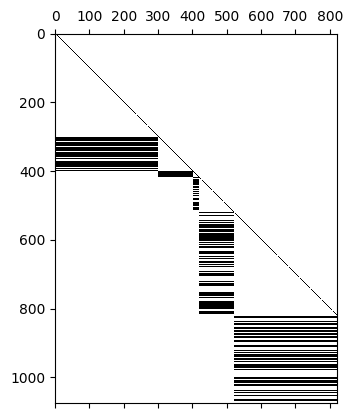

In [12]:
plt.spy(J)

Random-initialized model reconstruction results:


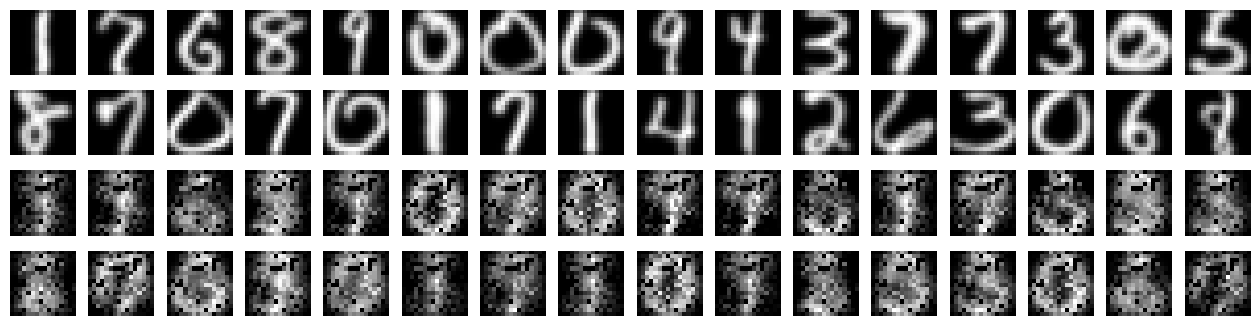

In [13]:
for x, _ in train_loader:
    x = x[32:64].to(device)
    with torch.no_grad():
        z = model(x)
    
    print('Random-initialized model reconstruction results:')
    plot_progress(x, z)
    
    break

In [55]:
%%time

relu = nn.ReLU()
line_search_c = pow(10,-4)
# backtracking multiplier
line_search_tau = 0.5
alphas_w = []
alphas_z = []
loss_hist = []
mu = 1.0

# registering hooks to cache activations
model = AE().to(device)

WEIGHTS = [
    model.encoder[0].weight.detach().cpu(),
    model.encoder[2].weight.detach().cpu(),
    model.encoder[4].weight.detach().cpu(),
    model.decoder[0].weight.detach().cpu(),
    model.decoder[2].weight.detach().cpu(),
    model.decoder[4].weight.detach().cpu(),
]

# sum of all output shapes
H = 0
h_k = [0]
for W in WEIGHTS:
    H += W.shape[0]
    h_k.append(W.shape[0] + h_k[-1])
h_k = h_k[1:]

CACHE_OUTPUTS = {}
CACHE_RELUS = {}

def cache_relu_hook(idx, module, input, output):
    CACHE_RELUS[idx] = output.detach().cpu()

i = 0 
for m in model.modules():
    if isinstance(m, nn.ReLU):
        handle = m.register_forward_hook(partial(cache_relu_hook, i))
        i += 1
        
# caching activations
with torch.no_grad():
    for x, _ in train_loader:
        x = x.to(device)
        _ = model(x)
        x = x.cpu()
        
        
with torch.no_grad():
    for epoch in range(10):
        
        # W-Step
        WEIGHTS_COPY = copy.deepcopy(WEIGHTS)

        for layer_idx in tqdm(range(len(CACHE_RELUS))):
            in_dim = WEIGHTS[layer_idx].shape[1]
            out_dim = WEIGHTS[layer_idx].shape[0]
            n_samples = CACHE_RELUS[layer_idx].shape[0]

            if layer_idx == 0:
                residuals = CACHE_RELUS[layer_idx] - relu(x @ WEIGHTS[layer_idx].T)
            elif layer_idx == len(CACHE_RELUS) - 1:
                # reconstruction task
                residuals = x - relu(CACHE_RELUS[layer_idx-1] @ WEIGHTS[layer_idx].T)
            else:
                residuals = CACHE_RELUS[layer_idx] - relu(CACHE_RELUS[layer_idx-1] @ WEIGHTS[layer_idx].T)
            # print('residuals:', residuals.shape)

            for h in range(out_dim):
                # Building Jacobian (for each layer and output dim)
                J = torch.zeros((n_samples, in_dim))
                w = WEIGHTS[layer_idx][h]

                if layer_idx == 0:
                    for n in range(n_samples):
                        if CACHE_RELUS[layer_idx][n][h] > 0:
                            J[n, :] = - x[n]
                else:
                    for n in range(n_samples):
                        if CACHE_RELUS[layer_idx][n][h] > 0:
                            J[n, :] = - CACHE_RELUS[layer_idx-1][n]

                p = torch.linalg.lstsq(J.T@J, - J.T @ residuals[:, h])[0]
                # print('shape of p:', p.shape, 'shape of w:', w.shape)
                # p.T @ grad (.T doesn't matter, numpy performs inner product)
                descent_inner_prod = (J.T @ residuals[:, h]) @ p
                try:
                    assert descent_inner_prod <= 0
                except:
                    pass
                    # print(f'layer {layer_idx+1} dim {h} descent(should be <= 0)', descent_inner_prod)

                # Line Search with Backtracking
                alpha = 1.0
                fw = (residuals[:,h]**2).sum() / 2
                # First Update
                w += alpha*p
                if layer_idx == 0:
                    residuals_new = CACHE_RELUS[layer_idx][:,h] - relu(torch.einsum('bq,q->b', x, w))
                elif layer_idx == len(CACHE_RELUS) - 1:
                    residuals_new = x[:,h] - relu(torch.einsum('bq,q->b', CACHE_RELUS[layer_idx-1], w))
                else:
                    residuals_new = CACHE_RELUS[layer_idx][:,h] - relu(torch.einsum('bq,q->b', CACHE_RELUS[layer_idx-1], w))
                fw_new = (residuals_new**2).sum() / 2
                rhs = alpha * line_search_c * descent_inner_prod

                max_iter, counter = 40, 0
                # Armijo Condition
                while fw_new - fw > rhs and counter < max_iter:
                    alpha *= line_search_tau
                    # Update
                    w = WEIGHTS_COPY[layer_idx][h] + alpha * p
                    if layer_idx == 0:
                        residuals_new = CACHE_RELUS[layer_idx][:,h] - relu(torch.einsum('bq,q->b', x, w))
                    else:
                        residuals_new = CACHE_RELUS[layer_idx][:,h] - relu(torch.einsum('bq,q->b', CACHE_RELUS[layer_idx-1], w))
                    fw_new = (residuals_new**2).sum() / 2
                    rhs = alpha * line_search_c * descent_inner_prod

                    # print("Line search armijo: obj func old: %f new: %f diff: %.16f rhs: %.16f, alpha: %f" % (fw, fw_new, fw_new - fw, rhs, alpha))
                    counter += 1
                # alphas_w.append(alpha)

        for layer_idx in range(len(CACHE_RELUS)):
            print(f'Layer {layer_idx}, '
                  f'Weights Diff Norm: {torch.linalg.norm(WEIGHTS[layer_idx]-WEIGHTS_COPY[layer_idx]) / torch.linalg.norm(WEIGHTS_COPY[layer_idx])}')
        model.encoder[0].weight.data = WEIGHTS[0]
        model.encoder[2].weight.data = WEIGHTS[1]
        model.encoder[4].weight.data = WEIGHTS[2]
        model.decoder[0].weight.data = WEIGHTS[3]
        model.decoder[2].weight.data = WEIGHTS[4]
        model.decoder[4].weight.data = WEIGHTS[5]
        model = model.to(device)
        
        # Removing Hooks
        for m in model.modules():
            if isinstance(m, nn.ReLU):
                m._forward_hooks = OrderedDict()
        # Loss on eval dataset
        loss = eval_loss(model, test_loader, loss_function, device=device)
        loss_hist.append(loss)
        print(f'Epoch {epoch+1}, Eval loss: {loss}')
        # Putting hooks back
        i = 0 
        for m in model.modules():
            if isinstance(m, nn.ReLU):
                handle = m.register_forward_hook(partial(cache_relu_hook, i))
                i += 1
        
        # # recalculating activations after weights update
        # for x, _ in train_loader:
        #     x = x.to(device)
        #     _ = model(x)
        #     x = x.cpu()

        # Z-Step
        CACHE_RELUS_COPY = copy.deepcopy(CACHE_RELUS)
            
        for n_sample in tqdm(range(len(x))):

            # Calculating Residuals
            residuals = torch.zeros(H)
            start = 0
            for layer_idx in range(len(h_k)):
                if layer_idx == 0:
                    residuals[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', x[n_sample], WEIGHTS[layer_idx]))
                elif layer_idx == len(CACHE_RELUS) - 1:
                    residuals[start:h_k[layer_idx]] = x[n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                else:
                    residuals[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                start = h_k[layer_idx]
            # Quadratic Penalty
            mu_mult = torch.ones_like(residuals)
            mu_mult[:h_k[-2]] = math.sqrt(mu)
            residuals = mu_mult * residuals

            # Building Jacobian for each sample in dataset
            J = torch.zeros((H, H))
            for h in range(H):
                if h < h_k[-2]: J[h, h] = 1
                for layer_idx in range(len(h_k)):
                    if h <= h_k[layer_idx]: break
                if layer_idx == 0: continue

                n_feature = h-h_k[layer_idx-1]-1
                assert n_feature >= 0 and n_feature < WEIGHTS[layer_idx].shape[0]

                if layer_idx == 1:
                    start, finish = 0, h_k[layer_idx-1]
                elif layer_idx > 1:
                    start, finish = h_k[layer_idx-2], h_k[layer_idx-1]
                # print(CACHE_RELUS[layer_idx][n_sample][n_feature])
                if CACHE_RELUS[layer_idx][n_sample][n_feature] > 0:
                    # print(start, finish, n_feature, WEIGHTS[layer_idx][n_feature].shape)
                    J[h, start:finish] = - WEIGHTS[layer_idx][n_feature]
                    # Quadratic Penalty
                    if layer_idx != len(CACHE_RELUS)-1:
                        J[h, start:finish] *= mu

            # Descent Direction
            p = torch.linalg.lstsq(J.T@J, - J.T @ residuals)[0]
            # print('shape of p:', p.shape, 'shape of w:', w.shape)
            # p.T @ grad (.T doesn't matter, numpy performs inner product)
            descent_inner_prod = (J.T @ residuals) @ p
            try:
                assert descent_inner_prod <= 0
            except:
                print(f'sample {n_sample} descent direction should be <= 0', descent_inner_prod)

            # Line Search with Backtracking
            alpha = 1.0
            fw = residuals.sum() / 2
            # update
            for layer_idx in range(len(CACHE_RELUS)):
                if layer_idx == 0:
                    start, finish = 0, h_k[layer_idx]
                else:
                    start, finish = h_k[layer_idx-1], h_k[layer_idx]

                CACHE_RELUS[layer_idx][n_sample] = CACHE_RELUS_COPY[layer_idx][n_sample] + alpha * p[start:finish]
                
            residuals_new = torch.zeros(H)
            start = 0
            for layer_idx in range(len(h_k)):
                if layer_idx == 0:
                    residuals_new[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', x[n_sample], WEIGHTS[layer_idx]))
                elif layer_idx == len(CACHE_RELUS) - 1:
                    residuals_new[start:h_k[layer_idx]] = x[n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                else:
                    residuals_new[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                start = h_k[layer_idx]
            # Quadratic Penalty
            residuals_new = mu_mult * residuals_new
            fw_new = (residuals_new**2).sum() / 2
            rhs = alpha * line_search_c * descent_inner_prod
            # print('fw:', fw, fw_new, rhs)
            

            max_iter, counter = 40, 0
            # Armijo Condition
            while fw_new - fw > rhs and counter < max_iter:
                # step update
                alpha *= line_search_tau
                
                # relus update
                for layer_idx in range(len(CACHE_RELUS)):
                    if layer_idx == 0:
                        start, finish = 0, h_k[layer_idx]
                    else:
                        start, finish = h_k[layer_idx-1], h_k[layer_idx]

                    CACHE_RELUS[layer_idx][n_sample] = CACHE_RELUS_COPY[layer_idx][n_sample] + alpha * p[start:finish]
                    
                # recompute residuals
                start = 0
                for layer_idx in range(len(h_k)):
                    if layer_idx == 0:
                        residuals_new[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', x[n_sample], WEIGHTS[layer_idx]))
                    elif layer_idx == len(CACHE_RELUS) - 1:
                        residuals_new[start:h_k[layer_idx]] = x[n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                    else:
                        residuals_new[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                    start = h_k[layer_idx]
                # Quadratic Penalty
                residuals_new = mu_mult * residuals_new
                fw_new = (residuals_new**2).sum() / 2
                rhs = alpha * line_search_c * descent_inner_prod

                # print("Line search armijo: obj func old: %f new: %f diff: %.16f rhs: %.16f, alpha: %f" % (fw, fw_new, fw_new - fw, rhs, alpha))
                counter += 1
        
        for layer_idx in range(len(CACHE_RELUS)):
            print(f'Layer {layer_idx} Activations Diff Norm: '
                  f'{torch.linalg.norm(CACHE_RELUS[layer_idx]-CACHE_RELUS_COPY[layer_idx]) / torch.linalg.norm(CACHE_RELUS_COPY[layer_idx])}')
            
        mu *= 4

        # print()

100%|██████████| 6/6 [01:56<00:00, 19.37s/it]

Layer 0, Weights Diff Norm: 9.252866584574804e-05
Layer 1, Weights Diff Norm: 8.079350664047524e-05
Layer 2, Weights Diff Norm: 0.0001753252581693232
Layer 3, Weights Diff Norm: 0.0003796993405558169
Layer 4, Weights Diff Norm: 0.00022098592307884246
Layer 5, Weights Diff Norm: 53.81589889526367


Epoch 1, Eval loss: 0.06152551621198654


100%|██████████| 7291/7291 [09:00<00:00, 13.50it/s]


Layer 0 Activations Diff Norm: 0.0
Layer 1 Activations Diff Norm: 0.0
Layer 2 Activations Diff Norm: 0.0
Layer 3 Activations Diff Norm: 0.0
Layer 4 Activations Diff Norm: 0.0
Layer 5 Activations Diff Norm: 0.0


100%|██████████| 6/6 [02:04<00:00, 20.71s/it]

Layer 0, Weights Diff Norm: 9.483759640716016e-06
Layer 1, Weights Diff Norm: 1.705144859442953e-05
Layer 2, Weights Diff Norm: 6.40711878077127e-05
Layer 3, Weights Diff Norm: 3.926243516616523e-05
Layer 4, Weights Diff Norm: 0.00011110241030110046
Layer 5, Weights Diff Norm: 0.21595144271850586


Epoch 2, Eval loss: 0.0618380606174469


100%|██████████| 7291/7291 [10:02<00:00, 12.10it/s]


Layer 0 Activations Diff Norm: 0.0
Layer 1 Activations Diff Norm: 0.0
Layer 2 Activations Diff Norm: 0.0
Layer 3 Activations Diff Norm: 0.0
Layer 4 Activations Diff Norm: 0.0
Layer 5 Activations Diff Norm: 0.0


100%|██████████| 6/6 [02:05<00:00, 20.85s/it]

Layer 0, Weights Diff Norm: 5.502930889633717e-06
Layer 1, Weights Diff Norm: 8.199510375561658e-06
Layer 2, Weights Diff Norm: 4.86737881146837e-05
Layer 3, Weights Diff Norm: 1.4566425306838937e-05
Layer 4, Weights Diff Norm: 0.0001587014994584024
Layer 5, Weights Diff Norm: 0.17921271920204163


Epoch 3, Eval loss: 0.061798013746738434


100%|██████████| 7291/7291 [10:48<00:00, 11.24it/s]


Layer 0 Activations Diff Norm: 0.0
Layer 1 Activations Diff Norm: 0.0
Layer 2 Activations Diff Norm: 0.0
Layer 3 Activations Diff Norm: 0.0
Layer 4 Activations Diff Norm: 0.0
Layer 5 Activations Diff Norm: 0.0


100%|██████████| 6/6 [02:05<00:00, 20.89s/it]

Layer 0, Weights Diff Norm: 2.906140025515924e-06
Layer 1, Weights Diff Norm: 5.2913201216142625e-06
Layer 2, Weights Diff Norm: 2.1502573872567154e-05
Layer 3, Weights Diff Norm: 0.00023309444077312946
Layer 4, Weights Diff Norm: 0.00013369151565711945
Layer 5, Weights Diff Norm: 0.14721262454986572


Epoch 4, Eval loss: 0.06213661655783653


100%|██████████| 7291/7291 [11:15<00:00, 10.80it/s]


Layer 0 Activations Diff Norm: 0.0
Layer 1 Activations Diff Norm: 0.0
Layer 2 Activations Diff Norm: 0.0
Layer 3 Activations Diff Norm: 0.0
Layer 4 Activations Diff Norm: 0.0
Layer 5 Activations Diff Norm: 0.0


100%|██████████| 6/6 [02:05<00:00, 20.98s/it]

Layer 0, Weights Diff Norm: 1.6730472225390258e-06
Layer 1, Weights Diff Norm: 4.2177903196716215e-06
Layer 2, Weights Diff Norm: 2.899955870816484e-05
Layer 3, Weights Diff Norm: 5.9269001212669536e-05
Layer 4, Weights Diff Norm: 7.168505544541404e-05
Layer 5, Weights Diff Norm: 0.07925637811422348


Epoch 5, Eval loss: 0.06229625642299652


100%|██████████| 7291/7291 [07:50<00:00, 15.49it/s]


Layer 0 Activations Diff Norm: 0.0
Layer 1 Activations Diff Norm: 0.0
Layer 2 Activations Diff Norm: 0.0
Layer 3 Activations Diff Norm: 0.0
Layer 4 Activations Diff Norm: 0.0
Layer 5 Activations Diff Norm: 0.0


100%|██████████| 6/6 [02:05<00:00, 20.95s/it]

Layer 0, Weights Diff Norm: 3.632222615124192e-06
Layer 1, Weights Diff Norm: 3.219540531063103e-06
Layer 2, Weights Diff Norm: 1.6122861779876985e-05
Layer 3, Weights Diff Norm: 3.613807564306626e-08
Layer 4, Weights Diff Norm: 9.381707786815241e-05
Layer 5, Weights Diff Norm: 0.11037002503871918


Epoch 6, Eval loss: 0.062200043350458145


  0%|          | 0/7291 [00:00<?, ?it/s]


Intel MKL ERROR: Parameter 4 was incorrect on entry to SGELSY.


RuntimeError: falseINTERNAL ASSERT FAILED at "../aten/src/ATen/native/LinearAlgebraUtils.h":328, please report a bug to PyTorch. torch.linalg.lstsq: Argument 4 has illegal value. Most certainly there is a bug in the implementation calling the backend library.

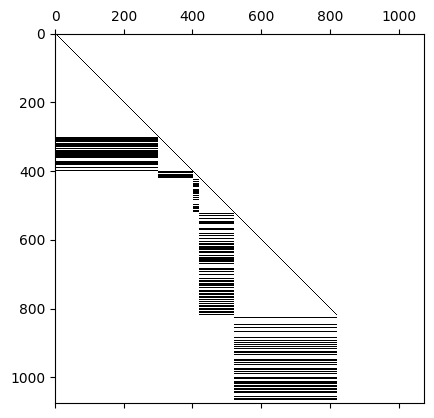

In [56]:
# Jacobian for Z-step
plt.spy(J)
plt.show()

Trained model reconstruction results:


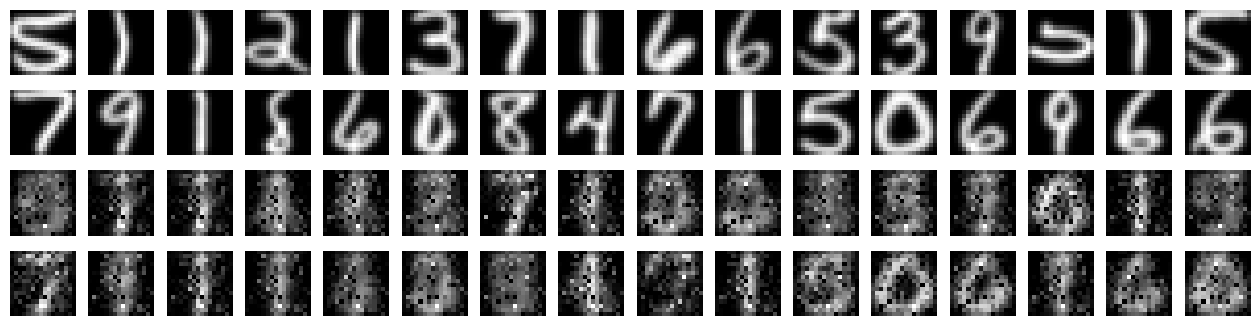

In [57]:
for x, _ in train_loader:
    x = x[:32].to(device)
    with torch.no_grad():
        z = model(x)
    
    print('Trained model reconstruction results:')
    plot_progress(x, z)
    
    break

In [58]:
print(f'Eval loss: {eval_loss(model, test_loader, loss_function, device=device)}')

Eval loss: 0.062200043350458145


In [51]:
%%time

relu = nn.ReLU()
line_search_c = pow(10,-4)
# backtracking multiplier
line_search_tau = 0.5
alphas_w = []
alphas_z = []
loss_hist = []

# registering hooks to cache activations
model = AE().to(device)

WEIGHTS = [
    model.encoder[0].weight.detach().cpu(),
    model.encoder[2].weight.detach().cpu(),
    model.encoder[4].weight.detach().cpu(),
    model.decoder[0].weight.detach().cpu(),
    model.decoder[2].weight.detach().cpu(),
    model.decoder[4].weight.detach().cpu(),
]

# sum of all output shapes
H = 0
h_k = [0]
for W in WEIGHTS:
    H += W.shape[0]
    h_k.append(W.shape[0] + h_k[-1])
h_k = h_k[1:]

CACHE_OUTPUTS = {}
CACHE_RELUS = {}

def cache_relu_hook(idx, module, input, output):
    CACHE_RELUS[idx] = output.detach().cpu()

i = 0 
for m in model.modules():
    if isinstance(m, nn.ReLU):
        handle = m.register_forward_hook(partial(cache_relu_hook, i))
        i += 1
        
# caching activations
with torch.no_grad():
    for x, _ in train_loader:
        x = x.to(device)
        _ = model(x)
        x = x.cpu()
        
        
with torch.no_grad():
    for epoch in range(10):
        
        # W-Step
        WEIGHTS_COPY = copy.deepcopy(WEIGHTS)

        for layer_idx in tqdm(range(len(CACHE_RELUS))):
            in_dim = WEIGHTS[layer_idx].shape[1]
            out_dim = WEIGHTS[layer_idx].shape[0]
            n_samples = CACHE_RELUS[layer_idx].shape[0]

            if layer_idx == 0:
                residuals = CACHE_RELUS[layer_idx] - relu(x @ WEIGHTS[layer_idx].T)
            elif layer_idx == len(CACHE_RELUS) - 1:
                # reconstruction task
                residuals = x - relu(CACHE_RELUS[layer_idx-1] @ WEIGHTS[layer_idx].T)
            else:
                residuals = CACHE_RELUS[layer_idx] - relu(CACHE_RELUS[layer_idx-1] @ WEIGHTS[layer_idx].T)
            # print('residuals:', residuals.shape)

            for h in range(out_dim):
                # Building Jacobian (for each layer and output dim)
                J = torch.zeros((n_samples, in_dim))
                w = WEIGHTS[layer_idx][h]

                if layer_idx == 0:
                    for n in range(n_samples):
                        if CACHE_RELUS[layer_idx][n][h] > 0:
                            J[n, :] = - x[n]
                else:
                    for n in range(n_samples):
                        if CACHE_RELUS[layer_idx][n][h] > 0:
                            J[n, :] = - CACHE_RELUS[layer_idx-1][n]

                p = torch.linalg.lstsq(J.T@J, - J.T @ residuals[:, h])[0]
                # print('shape of p:', p.shape, 'shape of w:', w.shape)
                # p.T @ grad (.T doesn't matter, numpy performs inner product)
                descent_inner_prod = (J.T @ residuals[:, h]) @ p
                try:
                    assert descent_inner_prod <= 0
                except:
                    pass
                    # print(f'layer {layer_idx+1} dim {h} descent(should be <= 0)', descent_inner_prod)

                # Line Search with Backtracking
                alpha = 1.0
                fw = (residuals[:,h]**2).sum() / 2
                # First Update
                w += alpha*p
                if layer_idx == 0:
                    residuals_new = CACHE_RELUS[layer_idx][:,h] - relu(torch.einsum('bq,q->b', x, w))
                elif layer_idx == len(CACHE_RELUS) - 1:
                    residuals_new = x[:,h] - relu(torch.einsum('bq,q->b', CACHE_RELUS[layer_idx-1], w))
                else:
                    residuals_new = CACHE_RELUS[layer_idx][:,h] - relu(torch.einsum('bq,q->b', CACHE_RELUS[layer_idx-1], w))
                fw_new = (residuals_new**2).sum() / 2
                rhs = alpha * line_search_c * descent_inner_prod

                max_iter, counter = 40, 0
                # Armijo Condition
                while fw_new - fw > rhs and counter < max_iter:
                    alpha *= line_search_tau
                    # Update
                    w = WEIGHTS_COPY[layer_idx][h] + alpha * p
                    if layer_idx == 0:
                        residuals_new = CACHE_RELUS[layer_idx][:,h] - relu(torch.einsum('bq,q->b', x, w))
                    else:
                        residuals_new = CACHE_RELUS[layer_idx][:,h] - relu(torch.einsum('bq,q->b', CACHE_RELUS[layer_idx-1], w))
                    fw_new = (residuals_new**2).sum() / 2
                    rhs = alpha * line_search_c * descent_inner_prod

                    # print("Line search armijo: obj func old: %f new: %f diff: %.16f rhs: %.16f, alpha: %f" % (fw, fw_new, fw_new - fw, rhs, alpha))
                    counter += 1
                # alphas_w.append(alpha)

        for layer_idx in range(len(CACHE_RELUS)):
            print(f'Layer {layer_idx}, '
                  f'Weights Diff Norm: {torch.linalg.norm(WEIGHTS[layer_idx]-WEIGHTS_COPY[layer_idx]) / torch.linalg.norm(WEIGHTS_COPY[layer_idx])}')
        model.encoder[0].weight.data = WEIGHTS[0]
        model.encoder[2].weight.data = WEIGHTS[1]
        model.encoder[4].weight.data = WEIGHTS[2]
        model.decoder[0].weight.data = WEIGHTS[3]
        model.decoder[2].weight.data = WEIGHTS[4]
        model.decoder[4].weight.data = WEIGHTS[5]
        model = model.to(device)
        
        # Removing Hooks
        for m in model.modules():
            if isinstance(m, nn.ReLU):
                m._forward_hooks = OrderedDict()
        # Loss on eval dataset
        loss = eval_loss(model, test_loader, loss_function, device=device)
        loss_hist.append(loss)
        print(f'Epoch {epoch+1}, Eval loss: {loss}')
        # Putting hooks back
        i = 0 
        for m in model.modules():
            if isinstance(m, nn.ReLU):
                handle = m.register_forward_hook(partial(cache_relu_hook, i))
                i += 1
        
        # recalculating activations after weights update
        for x, _ in train_loader:
            x = x.to(device)
            _ = model(x)
            x = x.cpu()

        # Z-Step
        CACHE_RELUS_COPY = copy.deepcopy(CACHE_RELUS)
            
        for n_sample in tqdm(range(len(x))):

            # Calculating Residuals
            residuals = torch.zeros(H)
            start = 0
            for layer_idx in range(len(h_k)):
                if layer_idx == 0:
                    residuals[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', x[n_sample], WEIGHTS[layer_idx]))
                elif layer_idx == len(CACHE_RELUS) - 1:
                    residuals[start:h_k[layer_idx]] = x[n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                else:
                    residuals[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                start = h_k[layer_idx]
            # Quadratic Penalty
            mu_mult = torch.ones_like(residuals)
            mu_mult[:h_k[-2]] = math.sqrt(mu)
            residuals = mu_mult * residuals

            # Building Jacobian for each sample in dataset
            J = torch.zeros((H, H))
            for h in range(H):
                if h < h_k[-2]: J[h, h] = 1
                for layer_idx in range(len(h_k)):
                    if h <= h_k[layer_idx]: break
                if layer_idx == 0: continue

                n_feature = h-h_k[layer_idx-1]-1
                assert n_feature >= 0 and n_feature < WEIGHTS[layer_idx].shape[0]

                if layer_idx == 1:
                    start, finish = 0, h_k[layer_idx-1]
                elif layer_idx > 1:
                    start, finish = h_k[layer_idx-2], h_k[layer_idx-1]
                # print(CACHE_RELUS[layer_idx][n_sample][n_feature])
                if CACHE_RELUS[layer_idx][n_sample][n_feature] > 0:
                    # print(start, finish, n_feature, WEIGHTS[layer_idx][n_feature].shape)
                    J[h, start:finish] = - WEIGHTS[layer_idx][n_feature]
                    # Quadratic Penalty
                    if layer_idx != len(CACHE_RELUS)-1:
                        J[h, start:finish] *= mu

            # Descent Direction
            p = torch.linalg.lstsq(J.T@J, - J.T @ residuals)[0]
            # print('shape of p:', p.shape, 'shape of w:', w.shape)
            # p.T @ grad (.T doesn't matter, numpy performs inner product)
            descent_inner_prod = (J.T @ residuals) @ p
            try:
                assert descent_inner_prod <= 0
            except:
                print(f'sample {n_sample} descent direction should be <= 0', descent_inner_prod)

            # Line Search with Backtracking
            alpha = 1.0
            fw = residuals.sum() / 2
            # update
            for layer_idx in range(len(CACHE_RELUS)):
                if layer_idx == 0:
                    start, finish = 0, h_k[layer_idx]
                else:
                    start, finish = h_k[layer_idx-1], h_k[layer_idx]

                CACHE_RELUS[layer_idx][n_sample] = CACHE_RELUS_COPY[layer_idx][n_sample] + alpha * p[start:finish]
                
            residuals_new = torch.zeros(H)
            start = 0
            for layer_idx in range(len(h_k)):
                if layer_idx == 0:
                    residuals_new[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', x[n_sample], WEIGHTS[layer_idx]))
                elif layer_idx == len(CACHE_RELUS) - 1:
                    residuals_new[start:h_k[layer_idx]] = x[n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                else:
                    residuals_new[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                start = h_k[layer_idx]
            # Quadratic Penalty
            residuals_new = mu_mult * residuals_new
            fw_new = (residuals_new**2).sum() / 2
            rhs = alpha * line_search_c * descent_inner_prod
            # print('fw:', fw, fw_new, rhs)
            

            max_iter, counter = 40, 0
            # Armijo Condition
            while fw_new - fw > rhs and counter < max_iter:
                # step update
                alpha *= line_search_tau
                
                # relus update
                for layer_idx in range(len(CACHE_RELUS)):
                    if layer_idx == 0:
                        start, finish = 0, h_k[layer_idx]
                    else:
                        start, finish = h_k[layer_idx-1], h_k[layer_idx]

                    CACHE_RELUS[layer_idx][n_sample] = CACHE_RELUS_COPY[layer_idx][n_sample] + alpha * p[start:finish]
                    
                # recompute residuals
                start = 0
                for layer_idx in range(len(h_k)):
                    if layer_idx == 0:
                        residuals_new[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', x[n_sample], WEIGHTS[layer_idx]))
                    elif layer_idx == len(CACHE_RELUS) - 1:
                        residuals_new[start:h_k[layer_idx]] = x[n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                    else:
                        residuals_new[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                    start = h_k[layer_idx]
                # Quadratic Penalty
                residuals_new = mu_mult * residuals_new
                fw_new = (residuals_new**2).sum() / 2
                rhs = alpha * line_search_c * descent_inner_prod

                # print("Line search armijo: obj func old: %f new: %f diff: %.16f rhs: %.16f, alpha: %f" % (fw, fw_new, fw_new - fw, rhs, alpha))
                counter += 1
        
        for layer_idx in range(len(CACHE_RELUS)):
            print(f'Layer {layer_idx} Activations Diff Norm: '
                  f'{torch.linalg.norm(CACHE_RELUS[layer_idx]-CACHE_RELUS_COPY[layer_idx]) / torch.linalg.norm(CACHE_RELUS_COPY[layer_idx])}')
            
        mu *= 4

        # print()

100%|██████████| 6/6 [01:54<00:00, 19.09s/it]

Layer 0, Weights Diff Norm: 7.568952423753217e-05
Layer 1, Weights Diff Norm: 7.839558384148404e-05
Layer 2, Weights Diff Norm: 0.00022436623112298548
Layer 3, Weights Diff Norm: 0.0004299689317122102
Layer 4, Weights Diff Norm: 4.5003755076322705e-05
Layer 5, Weights Diff Norm: 12.003912925720215


Epoch 1, Eval loss: 0.08763116598129272


100%|██████████| 7291/7291 [08:27<00:00, 14.35it/s]


Layer 0 Activations Diff Norm: 1.0414826922831126e-22
Layer 1 Activations Diff Norm: 0.0
Layer 2 Activations Diff Norm: 0.0
Layer 3 Activations Diff Norm: 0.0
Layer 4 Activations Diff Norm: 0.0
Layer 5 Activations Diff Norm: 0.0


100%|██████████| 6/6 [02:16<00:00, 22.77s/it]

Layer 0, Weights Diff Norm: 2.988283449667506e-05
Layer 1, Weights Diff Norm: 4.108197026653215e-05
Layer 2, Weights Diff Norm: 7.895260205259547e-05
Layer 3, Weights Diff Norm: 0.000332422845531255
Layer 4, Weights Diff Norm: 2.7074143872596323e-05
Layer 5, Weights Diff Norm: 1.4477218389511108


Epoch 2, Eval loss: 0.0752287358045578


100%|██████████| 7291/7291 [08:28<00:00, 14.34it/s]


Layer 0 Activations Diff Norm: 3.147341388298703e-23
Layer 1 Activations Diff Norm: 0.0
Layer 2 Activations Diff Norm: 0.0
Layer 3 Activations Diff Norm: 0.0
Layer 4 Activations Diff Norm: 0.0
Layer 5 Activations Diff Norm: 0.0


100%|██████████| 6/6 [02:09<00:00, 21.59s/it]

Layer 0, Weights Diff Norm: 2.4067305275821127e-05
Layer 1, Weights Diff Norm: 3.3578591683181e-05
Layer 2, Weights Diff Norm: 6.852474325569347e-05
Layer 3, Weights Diff Norm: 0.0010224052239209414
Layer 4, Weights Diff Norm: 2.5172186724375933e-05
Layer 5, Weights Diff Norm: 0.09272044152021408


Epoch 3, Eval loss: 0.06842724978923798


100%|██████████| 7291/7291 [08:42<00:00, 13.95it/s]


Layer 0 Activations Diff Norm: 3.0424381129197794e-24
Layer 1 Activations Diff Norm: 0.0
Layer 2 Activations Diff Norm: 0.0
Layer 3 Activations Diff Norm: 0.0
Layer 4 Activations Diff Norm: 0.0
Layer 5 Activations Diff Norm: 0.0


100%|██████████| 6/6 [02:10<00:00, 21.72s/it]

Layer 0, Weights Diff Norm: 2.0665169358835556e-05
Layer 1, Weights Diff Norm: 2.8643607947742566e-05
Layer 2, Weights Diff Norm: 7.214830111479387e-05
Layer 3, Weights Diff Norm: 0.0006283328402787447
Layer 4, Weights Diff Norm: 3.197519254172221e-05
Layer 5, Weights Diff Norm: 2.3097751140594482


Epoch 4, Eval loss: 0.06331782042980194


100%|██████████| 7291/7291 [08:52<00:00, 13.70it/s]


Layer 0 Activations Diff Norm: 0.0
Layer 1 Activations Diff Norm: 0.0
Layer 2 Activations Diff Norm: 0.0
Layer 3 Activations Diff Norm: 0.0
Layer 4 Activations Diff Norm: 0.0
Layer 5 Activations Diff Norm: 0.0


100%|██████████| 6/6 [02:09<00:00, 21.62s/it]

Layer 0, Weights Diff Norm: 1.767960020515602e-05
Layer 1, Weights Diff Norm: 2.6364026780356653e-05
Layer 2, Weights Diff Norm: 6.396291428245604e-05
Layer 3, Weights Diff Norm: 0.0008665069472044706
Layer 4, Weights Diff Norm: 2.1604104404104874e-05
Layer 5, Weights Diff Norm: 0.4806345999240875


Epoch 5, Eval loss: 0.06259052455425262


100%|██████████| 7291/7291 [08:56<00:00, 13.59it/s]


Layer 0 Activations Diff Norm: 0.0
Layer 1 Activations Diff Norm: 0.0
Layer 2 Activations Diff Norm: 0.0
Layer 3 Activations Diff Norm: 0.0
Layer 4 Activations Diff Norm: 0.0
Layer 5 Activations Diff Norm: 0.0


100%|██████████| 6/6 [02:09<00:00, 21.63s/it]

Layer 0, Weights Diff Norm: 1.4770761481486261e-05
Layer 1, Weights Diff Norm: 2.550770113884937e-05
Layer 2, Weights Diff Norm: 6.269845471251756e-05
Layer 3, Weights Diff Norm: 0.0006335765938274562
Layer 4, Weights Diff Norm: 2.050176408374682e-05
Layer 5, Weights Diff Norm: 0.24850249290466309


Epoch 6, Eval loss: 0.06255244463682175


100%|██████████| 7291/7291 [08:55<00:00, 13.61it/s]


Layer 0 Activations Diff Norm: 0.0
Layer 1 Activations Diff Norm: 0.0
Layer 2 Activations Diff Norm: 0.0
Layer 3 Activations Diff Norm: 0.0
Layer 4 Activations Diff Norm: 0.0
Layer 5 Activations Diff Norm: 0.0


100%|██████████| 6/6 [02:09<00:00, 21.51s/it]

Layer 0, Weights Diff Norm: 1.3451830454869196e-05
Layer 1, Weights Diff Norm: 2.2052401618566364e-05
Layer 2, Weights Diff Norm: 6.516986468341202e-05
Layer 3, Weights Diff Norm: 0.0005304958904162049
Layer 4, Weights Diff Norm: 1.6077656255220063e-05
Layer 5, Weights Diff Norm: 0.12255990505218506


Epoch 7, Eval loss: 0.06254546344280243


100%|██████████| 7291/7291 [08:51<00:00, 13.72it/s]


Layer 0 Activations Diff Norm: 0.0
Layer 1 Activations Diff Norm: 0.0
Layer 2 Activations Diff Norm: 0.0
Layer 3 Activations Diff Norm: 0.0
Layer 4 Activations Diff Norm: 0.0
Layer 5 Activations Diff Norm: 0.0


100%|██████████| 6/6 [02:09<00:00, 21.54s/it]

Layer 0, Weights Diff Norm: 1.1419416296121199e-05
Layer 1, Weights Diff Norm: 2.1679421479348093e-05
Layer 2, Weights Diff Norm: 4.738929055747576e-05
Layer 3, Weights Diff Norm: 0.0004967442946508527
Layer 4, Weights Diff Norm: 1.8424283553031273e-05
Layer 5, Weights Diff Norm: 0.0794801190495491


Epoch 8, Eval loss: 0.06254372000694275


100%|██████████| 7291/7291 [08:43<00:00, 13.92it/s]


Layer 0 Activations Diff Norm: 0.0
Layer 1 Activations Diff Norm: 0.0
Layer 2 Activations Diff Norm: 0.0
Layer 3 Activations Diff Norm: 0.0
Layer 4 Activations Diff Norm: 0.0
Layer 5 Activations Diff Norm: 0.0


100%|██████████| 6/6 [02:08<00:00, 21.49s/it]

Layer 0, Weights Diff Norm: 1.1817065569630358e-05
Layer 1, Weights Diff Norm: 2.2111114958534017e-05
Layer 2, Weights Diff Norm: 6.623224908253178e-05
Layer 3, Weights Diff Norm: 0.0004931375733576715
Layer 4, Weights Diff Norm: 1.66773097589612e-05
Layer 5, Weights Diff Norm: 0.008183520287275314


Epoch 9, Eval loss: 0.06254217028617859


100%|██████████| 7291/7291 [08:18<00:00, 14.62it/s]


Layer 0 Activations Diff Norm: 0.0
Layer 1 Activations Diff Norm: 0.0
Layer 2 Activations Diff Norm: 0.0
Layer 3 Activations Diff Norm: 0.0
Layer 4 Activations Diff Norm: 0.0
Layer 5 Activations Diff Norm: 0.0


100%|██████████| 6/6 [02:09<00:00, 21.53s/it]

Layer 0, Weights Diff Norm: 1.0128524081665091e-05
Layer 1, Weights Diff Norm: 1.8392011043033563e-05
Layer 2, Weights Diff Norm: 5.827877248520963e-05
Layer 3, Weights Diff Norm: 0.00063039775704965
Layer 4, Weights Diff Norm: 1.817988777474966e-05
Layer 5, Weights Diff Norm: 0.14669473469257355


Epoch 10, Eval loss: 0.062468271702528


100%|██████████| 7291/7291 [08:24<00:00, 14.44it/s]

Layer 0 Activations Diff Norm: 0.0
Layer 1 Activations Diff Norm: 0.0
Layer 2 Activations Diff Norm: 0.0
Layer 3 Activations Diff Norm: 0.0
Layer 4 Activations Diff Norm: 0.0
Layer 5 Activations Diff Norm: 0.0
CPU times: user 5h 12min 4s, sys: 29.4 s, total: 5h 12min 33s
Wall time: 1h 48min 36s


Trained model reconstruction results:


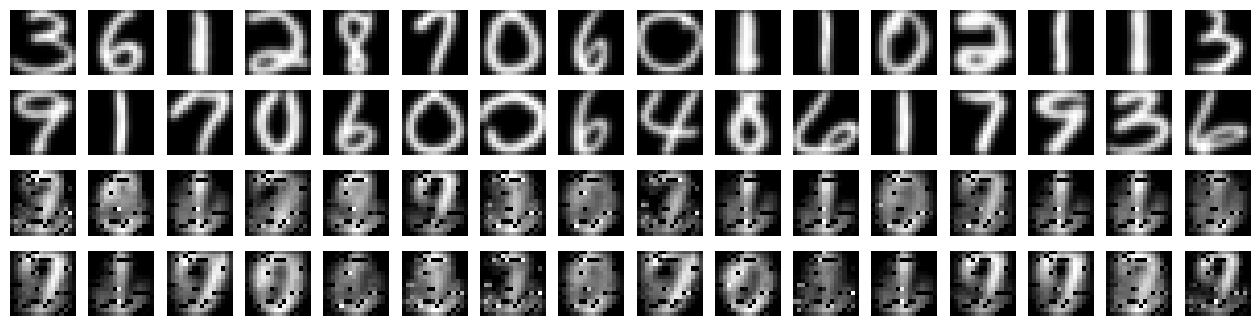

In [52]:
for x, _ in train_loader:
    x = x[:32].to(device)
    with torch.no_grad():
        z = model(x)
    
    print('Trained model reconstruction results:')
    plot_progress(x, z)
    
    break

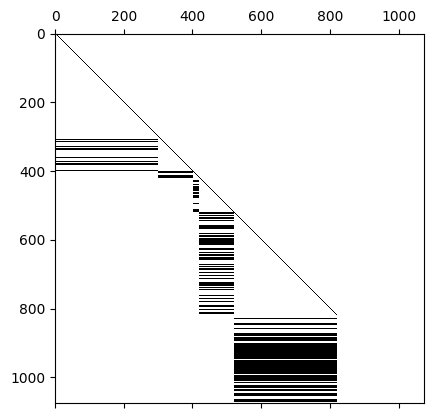

In [54]:
# Jacobian for Z-step
plt.spy(J)
plt.show()

## cpu, numpy, pool+map

In [5]:
device = 'cpu'

In [6]:
def relu(x):
    return np.maximum(0.0, x)

def calculate_z_residuals(cache_relus, x, h_k, WEIGHTS):
    
    residuals = np.zeros(h_k[-1])
    start = 0
    for layer_idx in range(len(h_k)):
        if layer_idx == 0:
            residuals[start:h_k[layer_idx]] = cache_relus[start:h_k[layer_idx]] - relu(np.einsum('q,hq->h', x, WEIGHTS[layer_idx]))
        elif layer_idx == 1:
            residuals[start:h_k[layer_idx]] = cache_relus[start:h_k[layer_idx]] \
                                              - relu(np.einsum('q,hq->h', cache_relus[:h_k[layer_idx-1]], 
                                                                             WEIGHTS[layer_idx]))
        elif layer_idx == len(h_k) - 1:
            residuals[start:h_k[layer_idx]] = x - relu(np.einsum('q,hq->h', cache_relus[h_k[layer_idx-2]:h_k[layer_idx-1]], WEIGHTS[layer_idx]))
        else:
            residuals[start:h_k[layer_idx]] = cache_relus[start:h_k[layer_idx]] \
                                              - relu(np.einsum('q,hq->h', cache_relus[h_k[layer_idx-2]:h_k[layer_idx-1]], 
                                                                             WEIGHTS[layer_idx]))
        start = h_k[layer_idx]
    return residuals

def z_step(n_sample, cache_relus, x, WEIGHTS, mu, h_k):
    
    # Calculating Residuals
    residuals = calculate_z_residuals(cache_relus, x, h_k, WEIGHTS)
    
    # Quadratic Penalty
    mu_mult = np.ones_like(residuals)
    mu_mult[:h_k[-2]] = math.sqrt(mu)
    residuals = mu_mult * residuals

    # Building Jacobian for each sample in dataset
    J = np.zeros((h_k[-1], h_k[-2]))
    for h in range(h_k[-1]):
        if h < h_k[-2]: J[h, h] = mu
        for layer_idx in range(len(h_k)):
            if h < h_k[layer_idx]: break
        if layer_idx == 0: continue

        n_feature = h-h_k[layer_idx-1]
        assert n_feature >= 0 and n_feature < WEIGHTS[layer_idx].shape[0]

        if layer_idx == 1:
            start, finish = 0, h_k[layer_idx-1]
        elif layer_idx > 1:
            start, finish = h_k[layer_idx-2], h_k[layer_idx-1]
        if cache_relus[h] > 0:
            J[h, start:finish] = - WEIGHTS[layer_idx][n_feature]
            # Quadratic Penalty
            if layer_idx != len(h_k)-1:
                J[h, start:finish] *= mu

    # Descent Direction
    p = np.linalg.lstsq(J.T@J, - J.T @ residuals, rcond=None)[0]
    # p.T @ grad (.T doesn't matter, numpy performs inner product)
    descent_inner_prod = (J.T @ residuals) @ p
    try:
        assert descent_inner_prod <= 0
    except:
        print(f'sample {n_sample} descent direction should be <= 0', descent_inner_prod)

    # Line Search with Backtracking
    alpha = 1.0
    fw = residuals.sum() / 2
    # recompute residuals with relus update
    p_ = np.zeros(h_k[-1])
    p_[:h_k[-2]] = p
    residuals_new = calculate_z_residuals(cache_relus + alpha * p_, x, h_k, WEIGHTS)

    # Quadratic Penalty
    residuals_new = mu_mult * residuals_new
    fw_new = (residuals_new**2).sum() / 2
    rhs = alpha * line_search_c * descent_inner_prod

    max_iter, counter = 40, 0
    # Armijo Condition
    while fw_new - fw > rhs and counter < max_iter:
        # step update
        alpha *= line_search_tau

        # recompute residuals with new relus update
        residuals_new = calculate_z_residuals(cache_relus + alpha * p_, x, h_k, WEIGHTS)

        # Quadratic Penalty
        residuals_new = mu_mult * residuals_new
        fw_new = (residuals_new**2).sum() / 2
        rhs = alpha * line_search_c * descent_inner_prod

        # print("Line search armijo: obj func old: %f new: %f diff: %.16f rhs: %.16f, alpha: %f" % (fw, fw_new, fw_new - fw, rhs, alpha))
        counter += 1
        
    return (n_sample, cache_relus + alpha * p_)

In [7]:
def relu(x):
    return np.maximum(0.0, x)

def calculate_w_residuals(layer_idx, h, w_h, x, CACHE_RELUS):
    
    if layer_idx == 0:
        residuals = CACHE_RELUS[layer_idx][:,h] - relu(np.einsum('bq,q->b', x, w_h))
    elif layer_idx == len(CACHE_RELUS) - 1:
        residuals = x[:,h] - relu(np.einsum('bq,q->b', CACHE_RELUS[layer_idx-1], w_h))
    else:
        residuals = CACHE_RELUS[layer_idx][:,h] - relu(np.einsum('bq,q->b', CACHE_RELUS[layer_idx-1], w_h))
        
    return residuals

def w_step(layer_idx, h, w_h, x, CACHE_RELUS, n_samples):
    
    residuals = calculate_w_residuals(layer_idx, h, w_h, x, CACHE_RELUS)
    
    # Building Jacobian (for each layer and output dim)
    J = np.zeros((n_samples, len(w_h)))

    if layer_idx == 0:
        for n in range(n_samples):
            if CACHE_RELUS[layer_idx][n][h] > 0:
                J[n, :] = - x[n]
    else:
        for n in range(n_samples):
            if CACHE_RELUS[layer_idx][n][h] > 0:
                J[n, :] = - CACHE_RELUS[layer_idx-1][n]

    p = np.linalg.lstsq(J.T@J, - J.T @ residuals, rcond=None)[0]
    # p.T @ grad (.T doesn't matter, numpy performs inner product)
    descent_inner_prod = (J.T @ residuals) @ p
    try:
        assert descent_inner_prod <= 0
    except:
        # pass
        print(f'layer {layer_idx+1} dim {h} descent(should be <= 0)', descent_inner_prod)

    # Line Search with Backtracking
    alpha = 1.0
    fw = (residuals**2).sum() / 2
    # First Update
    residuals_new = calculate_w_residuals(layer_idx, h, w_h + alpha*p, x, CACHE_RELUS)
    fw_new = (residuals_new**2).sum() / 2
    rhs = alpha * line_search_c * descent_inner_prod

    max_iter, counter = 40, 0
    # Armijo Condition
    while fw_new - fw > rhs and counter < max_iter:
        alpha *= line_search_tau
        # Update
        residuals_new = calculate_w_residuals(layer_idx, h, w_h + alpha*p, x, CACHE_RELUS)
        fw_new = (residuals_new**2).sum() / 2
        rhs = alpha * line_search_c * descent_inner_prod

        # print("Line search armijo: obj func old: %f new: %f diff: %.16f rhs: %.16f, alpha: %f" % (fw, fw_new, fw_new - fw, rhs, alpha))
        counter += 1
        
    return (layer_idx, h, w_h + alpha*p)

In [8]:
%%time

def relu(x):
    return np.maximum(0.0, x)

line_search_c = pow(10,-4)
# backtracking multiplier
line_search_tau = 0.5

# Quadratic Penalty multiplier 
mu = 1.0

loss_function = torch.nn.MSELoss()
loss_hist = []

# registering hooks to cache activations
model = AE().to(device)

WEIGHTS = [
    model.encoder[0].weight.detach().cpu().numpy(),
    model.encoder[2].weight.detach().cpu().numpy(),
    model.encoder[4].weight.detach().cpu().numpy(),
    model.decoder[0].weight.detach().cpu().numpy(),
    model.decoder[2].weight.detach().cpu().numpy(),
    model.decoder[4].weight.detach().cpu().numpy(),
]

# sum of all output shapes
H = 0
h_k = [0]
for W in WEIGHTS:
    H += W.shape[0]
    h_k.append(W.shape[0] + h_k[-1])
h_k = h_k[1:]

CACHE_RELUS = {}

def cache_relu_hook(idx, module, input, output):
    CACHE_RELUS[idx] = output.detach().cpu().numpy()

i = 0 
for m in model.modules():
    if isinstance(m, nn.ReLU):
        handle = m.register_forward_hook(partial(cache_relu_hook, i))
        i += 1
        
# caching activations
with torch.no_grad():
    for x, _ in train_loader:
        x = x.to(device)
        _ = model(x)
        x = x.detach().cpu().numpy()
        
# Removing Hooks
for m in model.modules():
    if isinstance(m, nn.ReLU):
        m._forward_hooks = OrderedDict()
        
def _get_cached_relus(n_sample):
    cache_relus = np.zeros(H)
    start = 0
    for layer_idx in range(len(h_k)):
        cache_relus[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample]
        start = h_k[layer_idx]
    return cache_relus

n_samples = x.shape[0]
print('n samples:', n_samples)
        
with torch.no_grad():
    for epoch in range(10):
        
        # W-Step
        WEIGHTS_COPY = copy.deepcopy(WEIGHTS)

        for layer_idx in tqdm(range(len(h_k))):

            # for h in range(out_dim):
            for h in range(5):
                w_h = WEIGHTS[layer_idx][h]
                w_step(layer_idx, h, w_h, x, CACHE_RELUS, n_samples)
                
        # with mp.Pool(processes=4) as pool:
        #     for layer_idx, h, new_w = pool.starmap(partial(w_step, n_samples=n_samples),
        #                                            ((layer_idx, h, WEIGHTS[layer_idx][h], x, CACHE_RELUS)
        #                                                for (layer_idx, h) in zip(range(len(h_k)), range()))
                
            # process for each unit in each layer
#             for h in range(5):
#                 w_h = WEIGHTS[layer_idx][h]
#                 p = mp.Process(target=partial(w_step, n_samples=n_samples),
#                                args=(layer_idx, h, in_dim, out_dim, w_h, x, CACHE_RELUS, queue))
#                 p.start()
#                 processes.append(p)

#         for p in processes:
#             p.join()
                
        # updating  WEIGHTS
        # for _ in tqdm(range(queue.qsize())):
        #     layer_idx, h, new_weights = queue.get()
        #     WEIGHTS[layer_idx][h] = new_weights

        # Checking Norm Difference
        for layer_idx in range(len(h_k)):
            print(f'Layer {layer_idx}, '
                  f'Weights Diff Norm: {np.linalg.norm(WEIGHTS[layer_idx]-WEIGHTS_COPY[layer_idx]) / np.linalg.norm(WEIGHTS_COPY[layer_idx])}')
        
        # Loading weights back to model to compute eval loss
        model.encoder[0].weight.data = torch.tensor(WEIGHTS[0])
        model.encoder[2].weight.data = torch.tensor(WEIGHTS[1])
        model.encoder[4].weight.data = torch.tensor(WEIGHTS[2])
        model.decoder[0].weight.data = torch.tensor(WEIGHTS[3])
        model.decoder[2].weight.data = torch.tensor(WEIGHTS[4])
        model.decoder[4].weight.data = torch.tensor(WEIGHTS[5])
        model = model.to(device)
        
        # Loss on eval dataset
        loss = eval_loss(model, test_loader, loss_function, device=device)
        loss_hist.append(loss)
        print(f'Epoch {epoch+1}, Eval loss: {loss}')
        
        # # recalculating activations after weights update
        # for x, _ in train_loader:
        #     x = x.to(device)
        #     _ = model(x)
        #     x = x.cpu()
    
        # Z-Step
        CACHE_RELUS_COPY = copy.deepcopy(CACHE_RELUS)
        
        # process for each sample
        # queue = mp.Queue()
        # processes = []
        # for n_sample in range(5):
        #     p = mp.Process(target=partial(z_step, mu=mu, H=H, h_k=h_k), 
        #                    args=(n_sample, _get_cached_relus(n_sample), x[n_sample], queue, WEIGHTS))
        #     p.start()
        #     processes.append(p)
        # for p in processes:
        #     p.join()
        with mp.Pool(processes=4) as pool:
            for n_sample, new_relus in pool.starmap(partial(z_step, mu=mu, h_k=h_k),
                                               ((n_sample, _get_cached_relus(n_sample), 
                                                 x[n_sample], WEIGHTS) for n_sample in range(n_samples))):
                # Updating CACHE_RELUS
                start = 0
                for layer_idx in range(len(h_k)):
                    CACHE_RELUS[layer_idx][n_sample] = new_relus[start:h_k[layer_idx]]
                    start = h_k[layer_idx]
            
        # Computing Relus Norm Difference
        for layer_idx in range(len(CACHE_RELUS)):
            print(f'Layer {layer_idx} Activations Diff Norm: '
                  f'{np.linalg.norm(CACHE_RELUS[layer_idx]-CACHE_RELUS_COPY[layer_idx]) / np.linalg.norm(CACHE_RELUS_COPY[layer_idx])}')
            
        mu *= 10
        break
        # print()

n samples: 7291


100%|██████████| 6/6 [00:01<00:00,  4.46it/s]

Layer 0, Weights Diff Norm: 0.0
Layer 1, Weights Diff Norm: 0.0
Layer 2, Weights Diff Norm: 0.0
Layer 3, Weights Diff Norm: 0.0
Layer 4, Weights Diff Norm: 0.0
Layer 5, Weights Diff Norm: 0.0


Epoch 1, Eval loss: 0.1618337482213974
Layer 0 Activations Diff Norm: 0.036658432334661484
Layer 1 Activations Diff Norm: 0.5135264992713928
Layer 2 Activations Diff Norm: 4.624906539916992
Layer 3 Activations Diff Norm: 10.30930233001709
Layer 4 Activations Diff Norm: 26.338945388793945
Layer 5 Activations Diff Norm: 0.0
CPU times: user 2.33 s, sys: 3.26 s, total: 5.59 s
Wall time: 13min 29s


In [78]:
device = 'cuda'

In [79]:
def calculate_z_residuals(cache_relus, x, H, h_k, WEIGHTS):
    
    relu = nn.ReLU()
    
    residuals = torch.zeros(H)
    start = 0
    for layer_idx in range(len(h_k)):
        if layer_idx == 0:
            residuals[start:h_k[layer_idx]] = cache_relus[start:h_k[layer_idx]] - relu(torch.einsum('q,hq->h', x, WEIGHTS[layer_idx]))
        elif layer_idx == 1:
            residuals[start:h_k[layer_idx]] = cache_relus[start:h_k[layer_idx]] \
                                              - relu(torch.einsum('q,hq->h', cache_relus[:h_k[layer_idx-1]], 
                                                                             WEIGHTS[layer_idx]))
        elif layer_idx == len(h_k) - 1:
            residuals[start:h_k[layer_idx]] = x - relu(torch.einsum('q,hq->h', cache_relus[h_k[layer_idx-2]:h_k[layer_idx-1]], WEIGHTS[layer_idx]))
        else:
            residuals[start:h_k[layer_idx]] = cache_relus[start:h_k[layer_idx]] \
                                              - relu(torch.einsum('q,hq->h', cache_relus[h_k[layer_idx-2]:h_k[layer_idx-1]], 
                                                                             WEIGHTS[layer_idx]))
        start = h_k[layer_idx]
    return residuals

def z_step(n_sample, cache_relus, x, WEIGHTS, mu, H, h_k):
    
    # Calculating Residuals
    residuals = calculate_z_residuals(cache_relus, x, H, h_k, WEIGHTS)
    
    # Quadratic Penalty
    mu_mult = torch.ones_like(residuals)
    mu_mult[:h_k[-2]] = math.sqrt(mu)
    residuals = mu_mult * residuals

    # Building Jacobian for each sample in dataset
    J = torch.zeros((H, H))
    for h in range(H):
        if h < h_k[-2]: J[h, h] = mu
        for layer_idx in range(len(h_k)):
            if h < h_k[layer_idx]: break
        if layer_idx == 0: continue

        n_feature = h-h_k[layer_idx-1]
        assert n_feature >= 0 and n_feature < WEIGHTS[layer_idx].shape[0]

        if layer_idx == 1:
            start, finish = 0, h_k[layer_idx-1]
        elif layer_idx > 1:
            start, finish = h_k[layer_idx-2], h_k[layer_idx-1]
        if cache_relus[h] > 0:
            J[h, start:finish] = - WEIGHTS[layer_idx][n_feature]
            # Quadratic Penalty
            if layer_idx != len(h_k)-1:
                J[h, start:finish] *= mu

    # Descent Direction
    p = torch.linalg.lstsq(J.T@J, - J.T @ residuals, rcond=None)[0]
    # p.T @ grad (.T doesn't matter, numpy performs inner product)
    descent_inner_prod = (J.T @ residuals) @ p
    try:
        assert descent_inner_prod <= 0
    except:
        print(f'sample {n_sample} descent direction should be <= 0', descent_inner_prod)

    # Line Search with Backtracking
    alpha = 1.0
    fw = residuals.sum() / 2
    # recompute residuals with relus update
    residuals_new = calculate_z_residuals(cache_relus + alpha * p, x, H, h_k, WEIGHTS)

    # Quadratic Penalty
    residuals_new = mu_mult * residuals_new
    fw_new = (residuals_new**2).sum() / 2
    rhs = alpha * line_search_c * descent_inner_prod

    max_iter, counter = 40, 0
    # Armijo Condition
    while fw_new - fw > rhs and counter < max_iter:
        # step update
        alpha *= line_search_tau

        # recompute residuals with new relus update
        residuals_new = calculate_z_residuals(cache_relus + alpha * p, x, H, h_k, WEIGHTS)

        # Quadratic Penalty
        residuals_new = mu_mult * residuals_new
        fw_new = (residuals_new**2).sum() / 2
        rhs = alpha * line_search_c * descent_inner_prod

        # print("Line search armijo: obj func old: %f new: %f diff: %.16f rhs: %.16f, alpha: %f" % (fw, fw_new, fw_new - fw, rhs, alpha))
        counter += 1
     
    return cache_relus + alpha * p

In [80]:
def calculate_w_residuals(layer_idx, h, w_h, x, CACHE_RELUS):
    
    relu = nn.ReLU()
    
    if layer_idx == 0:
        residuals = CACHE_RELUS[layer_idx][:,h] - relu(torch.einsum('bq,q->b', x, w_h))
    elif layer_idx == len(CACHE_RELUS) - 1:
        residuals = x[:,h] - relu(torch.einsum('bq,q->b', CACHE_RELUS[layer_idx-1], w_h))
    else:
        residuals = CACHE_RELUS[layer_idx][:,h] - relu(torch.einsum('bq,q->b', CACHE_RELUS[layer_idx-1], w_h))
        
    return residuals

def w_step(layer_idx, h, w_h, x, CACHE_RELUS, n_samples):
    residuals = calculate_w_residuals(layer_idx, h, w_h, x, CACHE_RELUS)
    
    # Building Jacobian (for each layer and output dim)
    J = torch.zeros((n_samples, len(w_h)))

    if layer_idx == 0:
        for n in range(n_samples):
            if CACHE_RELUS[layer_idx][n][h] > 0:
                J[n, :] = - x[n]
    else:
        for n in range(n_samples):
            if CACHE_RELUS[layer_idx][n][h] > 0:
                J[n, :] = - CACHE_RELUS[layer_idx-1][n]

    p = torch.linalg.lstsq(J.T@J, - J.T @ residuals, rcond=None)[0]
    # p.T @ grad (.T doesn't matter, numpy performs inner product)
    descent_inner_prod = (J.T @ residuals) @ p
    try:
        assert descent_inner_prod <= 0
    except:
        # pass
        print(f'layer {layer_idx+1} dim {h} descent(should be <= 0)', descent_inner_prod)

    # Line Search with Backtracking
    alpha = 1.0
    fw = (residuals**2).sum() / 2
    # First Update
    residuals_new = calculate_w_residuals(layer_idx, h, w_h + alpha*p, x, CACHE_RELUS)
    fw_new = (residuals_new**2).sum() / 2
    rhs = alpha * line_search_c * descent_inner_prod

    max_iter, counter = 40, 0
    # Armijo Condition
    while fw_new - fw > rhs and counter < max_iter:
        alpha *= line_search_tau
        # Update
        residuals_new = calculate_w_residuals(layer_idx, h, w_h + alpha*p, x, CACHE_RELUS)
        fw_new = (residuals_new**2).sum() / 2
        rhs = alpha * line_search_c * descent_inner_prod

        # print("Line search armijo: obj func old: %f new: %f diff: %.16f rhs: %.16f, alpha: %f" % (fw, fw_new, fw_new - fw, rhs, alpha))
        counter += 1
        
    return w_h + alpha*p

In [81]:
%%time

relu = nn.ReLU()

line_search_c = pow(10,-4)
# backtracking multiplier
line_search_tau = 0.5

# Quadratic Penalty multiplier 
mu = 1.0

loss_function = torch.nn.MSELoss()
loss_hist = []

# registering hooks to cache activations
model = AE().to(device)

WEIGHTS = [
    model.encoder[0].weight.detach().cpu(),
    model.encoder[2].weight.detach().cpu(),
    model.encoder[4].weight.detach().cpu(),
    model.decoder[0].weight.detach().cpu(),
    model.decoder[2].weight.detach().cpu(),
    model.decoder[4].weight.detach().cpu(),
]

# sum of all output shapes
H = 0
h_k = [0]
for W in WEIGHTS:
    H += W.shape[0]
    h_k.append(W.shape[0] + h_k[-1])
h_k = h_k[1:]

CACHE_RELUS = {}

def cache_relu_hook(idx, module, input, output):
    CACHE_RELUS[idx] = output.detach().cpu()

i = 0 
for m in model.modules():
    if isinstance(m, nn.ReLU):
        handle = m.register_forward_hook(partial(cache_relu_hook, i))
        i += 1
        
# caching activations
with torch.no_grad():
    for x, _ in train_loader:
        x = x.to(device)
        _ = model(x)
        x = x.detach().cpu()
        
# Removing Hooks
for m in model.modules():
    if isinstance(m, nn.ReLU):
        m._forward_hooks = OrderedDict()
        
def _get_cached_relus(n_sample):
    cache_relus = torch.zeros(H)
    start = 0
    for layer_idx in range(len(h_k)):
        cache_relus[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample]
        start = h_k[layer_idx]
    return cache_relus

n_samples = x.shape[0]
print('n samples:', n_samples)
        
with torch.no_grad():
    for epoch in range(10):
        
        # W-Step
        WEIGHTS_COPY = copy.deepcopy(WEIGHTS)

        for layer_idx in tqdm(range(len(h_k))):

            # for h in range(WEIGHTS[layer_idx].shape[0]):
            for h in range(5):
                w_h = WEIGHTS[layer_idx][h]
                new_w_h = w_step(layer_idx, h, w_h, x, CACHE_RELUS, n_samples)
                WEIGHTS[layer_idx][h] = new_w_h
                    
        # Checking Norm Difference
        for layer_idx in range(len(h_k)):
            print(f'Layer {layer_idx}, '
                  f'Weights Diff Norm: {torch.linalg.norm(WEIGHTS[layer_idx]-WEIGHTS_COPY[layer_idx]) / torch.linalg.norm(WEIGHTS_COPY[layer_idx])}')
        
        # Loading weights back to model to compute eval loss
        model.encoder[0].weight.data = WEIGHTS[0]
        model.encoder[2].weight.data = WEIGHTS[1]
        model.encoder[4].weight.data = WEIGHTS[2]
        model.decoder[0].weight.data = WEIGHTS[3]
        model.decoder[2].weight.data = WEIGHTS[4]
        model.decoder[4].weight.data = WEIGHTS[5]
        model = model.to(device)
        
        # Loss on eval dataset
        loss = eval_loss(model, test_loader, loss_function, device=device)
        loss_hist.append(loss)
        print(f'Epoch {epoch+1}, Eval loss: {loss}')
        
        # # recalculating activations after weights update
        # for x, _ in train_loader:
        #     x = x.to(device)
        #     _ = model(x)
        #     x = x.cpu()
    
        # Z-Step
        CACHE_RELUS_COPY = copy.deepcopy(CACHE_RELUS)
        
        # process for each sample
        for n_sample in tqdm(range(n_samples)):
            new_relus = z_step(n_sample, _get_cached_relus(n_sample), x[n_sample], WEIGHTS, mu, H, h_k)
            start = 0
            for layer_idx in range(len(h_k)):
                CACHE_RELUS[layer_idx][n_sample] = new_relus[start:h_k[layer_idx]]
                start = h_k[layer_idx]

        # Computing Relus Norm Difference
        for layer_idx in range(len(CACHE_RELUS)):
            print(f'Layer {layer_idx} Activations Diff Norm: '
                  f'{torch.linalg.norm(CACHE_RELUS[layer_idx]-CACHE_RELUS_COPY[layer_idx]) / torch.linalg.norm(CACHE_RELUS_COPY[layer_idx])}')
            
        mu *= 10
        break
        # print()

n samples: 7291


100%|██████████| 6/6 [00:03<00:00,  1.84it/s]

Layer 0, Weights Diff Norm: 6.4220453168672975e-06
Layer 1, Weights Diff Norm: 1.614207576494664e-05
Layer 2, Weights Diff Norm: 5.0705184548860416e-05
Layer 3, Weights Diff Norm: 0.00011182978050783277
Layer 4, Weights Diff Norm: 8.322960638906807e-06
Layer 5, Weights Diff Norm: 0.0


Epoch 1, Eval loss: 0.16191048920154572


100%|██████████| 7291/7291 [07:08<00:00, 17.00it/s]

Layer 0 Activations Diff Norm: 0.014977892860770226
Layer 1 Activations Diff Norm: 0.09165359288454056
Layer 2 Activations Diff Norm: 0.8426288366317749
Layer 3 Activations Diff Norm: 2.8289988040924072
Layer 4 Activations Diff Norm: 16.431354522705078
Layer 5 Activations Diff Norm: 0.0
CPU times: user 23min 27s, sys: 3.76 s, total: 23min 30s
Wall time: 7min 17s


## cpu, numpy, multiprocessing

In [ ]:
def relu(x):
    return np.maximum(0.0, x)

def calculate_z_residuals(cache_relus, x, h_k, WEIGHTS):
    
    residuals = np.zeros(h_k[-1])
    start = 0
    for layer_idx in range(len(h_k)):
        if layer_idx == 0:
            residuals[start:h_k[layer_idx]] = cache_relus[start:h_k[layer_idx]] - relu(np.einsum('q,hq->h', x, WEIGHTS[layer_idx]))
        elif layer_idx == 1:
            residuals[start:h_k[layer_idx]] = cache_relus[start:h_k[layer_idx]] \
                                              - relu(np.einsum('q,hq->h', cache_relus[:h_k[layer_idx-1]], 
                                                                             WEIGHTS[layer_idx]))
        elif layer_idx == len(h_k) - 1:
            residuals[start:h_k[layer_idx]] = x - relu(np.einsum('q,hq->h', cache_relus[h_k[layer_idx-2]:h_k[layer_idx-1]], WEIGHTS[layer_idx]))
        else:
            residuals[start:h_k[layer_idx]] = cache_relus[start:h_k[layer_idx]] \
                                              - relu(np.einsum('q,hq->h', cache_relus[h_k[layer_idx-2]:h_k[layer_idx-1]], 
                                                                             WEIGHTS[layer_idx]))
        start = h_k[layer_idx]
    return residuals

def z_step(n_sample, cache_relus, x, queue, WEIGHTS, mu, h_k):
    
    # Calculating Residuals
    residuals = calculate_z_residuals(cache_relus, x, h_k, WEIGHTS)
    
    # Quadratic Penalty
    mu_mult = np.ones_like(residuals)
    mu_mult[:h_k[-2]] = math.sqrt(mu)
    residuals = mu_mult * residuals

    # Building Jacobian for each sample in dataset
    J = np.zeros((h_k[-1], h_k[-2]))
    for h in range(Hh_k[-1]):
        if h < h_k[-2]: J[h, h] = mu
        for layer_idx in range(len(h_k)):
            if h < h_k[layer_idx]: break
        if layer_idx == 0: continue

        n_feature = h-h_k[layer_idx-1]
        assert n_feature >= 0 and n_feature < WEIGHTS[layer_idx].shape[0]

        if layer_idx == 1:
            start, finish = 0, h_k[layer_idx-1]
        elif layer_idx > 1:
            start, finish = h_k[layer_idx-2], h_k[layer_idx-1]
        if cache_relus[h] > 0:
            J[h, start:finish] = - WEIGHTS[layer_idx][n_feature]
            # Quadratic Penalty
            if layer_idx != len(h_k)-1:
                J[h, start:finish] *= mu

    # Descent Direction
    p = np.linalg.lstsq(J.T@J, - J.T @ residuals, rcond=None)[0]
    # p.T @ grad (.T doesn't matter, numpy performs inner product)
    descent_inner_prod = (J.T @ residuals) @ p
    try:
        assert descent_inner_prod <= 0
    except:
        print(f'sample {n_sample} descent direction should be <= 0', descent_inner_prod)

    # Line Search with Backtracking
    alpha = 1.0
    fw = residuals.sum() / 2
    # recompute residuals with relus update
    residuals_new = calculate_z_residuals(cache_relus + alpha * p_, x, h_k, WEIGHTS)

    # Quadratic Penalty
    residuals_new = mu_mult * residuals_new
    fw_new = (residuals_new**2).sum() / 2
    rhs = alpha * line_search_c * descent_inner_prod

    max_iter, counter = 40, 0
    # Armijo Condition
    while fw_new - fw > rhs and counter < max_iter:
        # step update
        alpha *= line_search_tau

        # recompute residuals with new relus update
        residuals_new = calculate_z_residuals(cache_relus + alpha * p_, x, h_k, WEIGHTS)

        # Quadratic Penalty
        residuals_new = mu_mult * residuals_new
        fw_new = (residuals_new**2).sum() / 2
        rhs = alpha * line_search_c * descent_inner_prod

        # print("Line search armijo: obj func old: %f new: %f diff: %.16f rhs: %.16f, alpha: %f" % (fw, fw_new, fw_new - fw, rhs, alpha))
        counter += 1
        
    queue.put((n_sample, cache_relus + alpha * p_))

In [ ]:
def relu(x):
    return np.maximum(0.0, x)

def calculate_w_residuals(layer_idx, h, w_h, x, CACHE_RELUS):
    
    if layer_idx == 0:
        residuals = CACHE_RELUS[layer_idx][:,h] - relu(np.einsum('bq,q->b', x, w_h))
    elif layer_idx == len(CACHE_RELUS) - 1:
        residuals = x[:,h] - relu(np.einsum('bq,q->b', CACHE_RELUS[layer_idx-1], w_h))
    else:
        residuals = CACHE_RELUS[layer_idx][:,h] - relu(np.einsum('bq,q->b', CACHE_RELUS[layer_idx-1], w_h))
        
    return residuals

def w_step(layer_idx, h, in_dim, out_dim, w_h, x, CACHE_RELUS, queue, n_samples):
    
    residuals = calculate_w_residuals(layer_idx, h, w_h, x, CACHE_RELUS)
    
    # Building Jacobian (for each layer and output dim)
    J = np.zeros((n_samples, in_dim))

    if layer_idx == 0:
        for n in range(n_samples):
            if CACHE_RELUS[layer_idx][n][h] > 0:
                J[n, :] = - x[n]
    else:
        for n in range(n_samples):
            if CACHE_RELUS[layer_idx][n][h] > 0:
                J[n, :] = - CACHE_RELUS[layer_idx-1][n]

    p = np.linalg.lstsq(J.T@J, - J.T @ residuals, rcond=None)[0]
    # p.T @ grad (.T doesn't matter, numpy performs inner product)
    descent_inner_prod = (J.T @ residuals) @ p
    try:
        assert descent_inner_prod <= 0
    except:
        # pass
        print(f'layer {layer_idx+1} dim {h} descent(should be <= 0)', descent_inner_prod)

    # Line Search with Backtracking
    alpha = 1.0
    fw = (residuals**2).sum() / 2
    # First Update
    residuals_new = calculate_w_residuals(layer_idx, h, w_h + alpha*p, x, CACHE_RELUS)
    fw_new = (residuals_new**2).sum() / 2
    rhs = alpha * line_search_c * descent_inner_prod

    max_iter, counter = 40, 0
    # Armijo Condition
    while fw_new - fw > rhs and counter < max_iter:
        alpha *= line_search_tau
        # Update
        residuals_new = calculate_w_residuals(layer_idx, h, w_h + alpha*p, x, CACHE_RELUS)
        fw_new = (residuals_new**2).sum() / 2
        rhs = alpha * line_search_c * descent_inner_prod

        # print("Line search armijo: obj func old: %f new: %f diff: %.16f rhs: %.16f, alpha: %f" % (fw, fw_new, fw_new - fw, rhs, alpha))
        counter += 1
        
    queue.put((layer_idx, h, w_h + alpha*p))

In [ ]:
%%time

def relu(x):
    return np.maximum(0.0, x)

line_search_c = pow(10,-4)
# backtracking multiplier
line_search_tau = 0.5

# Quadratic Penalty multiplier 
mu = 1.0

loss_function = torch.nn.MSELoss()
loss_hist = []

# registering hooks to cache activations
model = AE().to(device)
eval_loss = eval_loss(model, test_loader, loss_function, device=device)
loss_hist.append(eval_loss)

WEIGHTS = [
    model.encoder[0].weight.detach().cpu().numpy(),
    model.encoder[2].weight.detach().cpu().numpy(),
    model.encoder[4].weight.detach().cpu().numpy(),
    model.decoder[0].weight.detach().cpu().numpy(),
    model.decoder[2].weight.detach().cpu().numpy(),
    model.decoder[4].weight.detach().cpu().numpy(),
]

# sum of all output shapes
h_k = [0]
for W in WEIGHTS:
    h_k.append(W.shape[0] + h_k[-1])
h_k = h_k[1:]

CACHE_RELUS = {}

def cache_relu_hook(idx, module, input, output):
    CACHE_RELUS[idx] = output.detach().cpu().numpy()

i = 0 
for m in model.modules():
    if isinstance(m, nn.ReLU):
        handle = m.register_forward_hook(partial(cache_relu_hook, i))
        i += 1
        
# caching activations
with torch.no_grad():
    for x, _ in train_loader:
        x = x.to(device)
        _ = model(x)
        x = x.detach().cpu().numpy()
        
# Removing Hooks
for m in model.modules():
    if isinstance(m, nn.ReLU):
        m._forward_hooks = OrderedDict()
        
def _get_cached_relus(n_sample):
    cache_relus = np.zeros(H)
    start = 0
    for layer_idx in range(len(h_k)):
        cache_relus[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample]
        start = h_k[layer_idx]
    return cache_relus

n_samples = x.shape[0]
print('n samples:', n_samples)
        
with torch.no_grad():
    for epoch in range(10):
        
        # W-Step
        WEIGHTS_COPY = copy.deepcopy(WEIGHTS)
        queue = mp.Queue()
        processes = []

        for layer_idx in tqdm(range(len(h_k))):
            in_dim = WEIGHTS[layer_idx].shape[1]
            out_dim = WEIGHTS[layer_idx].shape[0]

            # for h in range(out_dim):
            for h in range(5):
                w_h = WEIGHTS[layer_idx][h]
                w_step(layer_idx, h, in_dim, out_dim, w_h, x, CACHE_RELUS, queue, n_samples)
                
            # process for each unit in each layer
#             for h in range(5):
#                 w_h = WEIGHTS[layer_idx][h]
#                 p = mp.Process(target=partial(w_step, n_samples=n_samples),
#                                args=(layer_idx, h, in_dim, out_dim, w_h, x, CACHE_RELUS, queue))
#                 p.start()
#                 processes.append(p)

#         for p in processes:
#             p.join()
                
        # updating  WEIGHTS
        for _ in tqdm(range(queue.qsize())):
            layer_idx, h, new_weights = queue.get()
            WEIGHTS[layer_idx][h] = new_weights

        # Checking Norm Difference
        for layer_idx in range(len(h_k)):
            print(f'Layer {layer_idx}, '
                  f'Weights Diff Norm: {np.linalg.norm(WEIGHTS[layer_idx]-WEIGHTS_COPY[layer_idx]) / np.linalg.norm(WEIGHTS_COPY[layer_idx])}')
        
        # Loading weights back to model to compute eval loss
        model.encoder[0].weight.data = torch.tensor(WEIGHTS[0])
        model.encoder[2].weight.data = torch.tensor(WEIGHTS[1])
        model.encoder[4].weight.data = torch.tensor(WEIGHTS[2])
        model.decoder[0].weight.data = torch.tensor(WEIGHTS[3])
        model.decoder[2].weight.data = torch.tensor(WEIGHTS[4])
        model.decoder[4].weight.data = torch.tensor(WEIGHTS[5])
        model = model.to(device)
        
        # Loss on eval dataset
        loss = eval_loss(model, test_loader, loss_function, device=device)
        loss_hist.append(loss)
        print(f'Epoch {epoch+1}, Eval loss: {loss}')
        
        # # recalculating activations after weights update
        # for x, _ in train_loader:
        #     x = x.to(device)
        #     _ = model(x)
        #     x = x.cpu()
    
        # Z-Step
        CACHE_RELUS_COPY = copy.deepcopy(CACHE_RELUS)
        
        # process for each sample
        queue = mp.Queue()
        processes = []
        for n_sample in range(5):
            p = mp.Process(target=partial(z_step, mu=mu, h_k=h_k), 
                           args=(n_sample, _get_cached_relus(n_sample), x[n_sample], queue, WEIGHTS))
            p.start()
            processes.append(p)
        for p in processes:
            p.join()
            
        # Updating CACHE_RELUS
        for _ in tqdm(range(queue.qsize())):
            n_sample, new_relus = queue.get()
            start = 0
            for layer_idx in range(len(h_k)):
                CACHE_RELUS[layer_idx][n_sample] = new_relus[start:h_k[layer_idx]]
                start = h_k[layer_idx]
            
        # Computing Relus Norm Difference
        for layer_idx in range(len(CACHE_RELUS)):
            print(f'Layer {layer_idx} Activations Diff Norm: '
                  f'{np.linalg.norm(CACHE_RELUS[layer_idx]-CACHE_RELUS_COPY[layer_idx]) / np.linalg.norm(CACHE_RELUS_COPY[layer_idx])}')
            
        mu *= 10
        break
        # print()

## on cpu, randomly initialized z

In [35]:
%%time

relu = nn.ReLU()
line_search_c = pow(10,-4)
# Quadratic Penalty Multiplier
mu = 1.0
# backtracking multiplier
line_search_tau = 0.5
alphas_w = []
alphas_z = []
loss_hist = []

# registering hooks to cache activations
model = AE().to(device)

WEIGHTS = [
    model.encoder[0].weight.detach().cpu(),
    model.encoder[2].weight.detach().cpu(),
    model.encoder[4].weight.detach().cpu(),
    model.decoder[0].weight.detach().cpu(),
    model.decoder[2].weight.detach().cpu(),
    model.decoder[4].weight.detach().cpu(),
]

# sum of all output shapes
H = 0
h_k = [0]
for W in WEIGHTS:
    H += W.shape[0]
    h_k.append(W.shape[0] + h_k[-1])
h_k = h_k[1:]

CACHE_RELUS = {}

def cache_relu_hook(idx, module, input, output):
    CACHE_RELUS[idx] = output.detach().cpu().numpy()

i = 0 
for m in model.modules():
    if isinstance(m, nn.ReLU):
        handle = m.register_forward_hook(partial(cache_relu_hook, i))
        i += 1
        
# caching activations
with torch.no_grad():
    for x, _ in train_loader:
        x = x.to(device)
        _ = model(x)
        x = x.detach().cpu()
    
with torch.no_grad():
    for epoch in range(1):
        
        # W-Step
        WEIGHTS_COPY = copy.deepcopy(WEIGHTS)

        for layer_idx in tqdm(range(len(CACHE_RELUS))):
            in_dim = WEIGHTS[layer_idx].shape[1]
            out_dim = WEIGHTS[layer_idx].shape[0]
            n_samples = CACHE_RELUS[layer_idx].shape[0]

            if layer_idx == 0:
                residuals = CACHE_RELUS[layer_idx] - relu(x @ WEIGHTS[layer_idx].T)
            elif layer_idx == len(CACHE_RELUS) - 1:
                # reconstruction task
                residuals = x - relu(CACHE_RELUS[layer_idx-1] @ WEIGHTS[layer_idx].T)
            else:
                residuals = CACHE_RELUS[layer_idx] - relu(CACHE_RELUS[layer_idx-1] @ WEIGHTS[layer_idx].T)
            # print('residuals:', residuals.shape)

            # for h in range(out_dim):
            for h in range(3):
                # Building Jacobian (for each layer and output dim)
                J = torch.zeros((n_samples, in_dim))
                w = WEIGHTS[layer_idx][h]

                if layer_idx == 0:
                    for n in range(n_samples):
                        if CACHE_RELUS[layer_idx][n][h] > 0:
                            J[n, :] = - x[n]
                else:
                    for n in range(n_samples):
                        if CACHE_RELUS[layer_idx][n][h] > 0:
                            J[n, :] = - CACHE_RELUS[layer_idx-1][n]

                p = torch.linalg.lstsq(J.T@J, - J.T @ residuals[:, h])[0]
                # print('shape of p:', p.shape, 'shape of w:', w.shape)
                # p.T @ grad (.T doesn't matter, numpy performs inner product)
                descent_inner_prod = (J.T @ residuals[:, h]) @ p
                try:
                    assert descent_inner_prod <= 0
                except:
                    pass
                    # print(f'layer {layer_idx+1} dim {h} descent(should be <= 0)', descent_inner_prod)

                # Line Search with Backtracking
                alpha = 1.0
                fw = (residuals[:,h]**2).sum() / 2
                # First Update
                w += alpha*p
                if layer_idx == 0:
                    residuals_new = CACHE_RELUS[layer_idx][:,h] - relu(torch.einsum('bq,q->b', x, w))
                elif layer_idx == len(CACHE_RELUS) - 1:
                    residuals_new = x[:,h] - relu(torch.einsum('bq,q->b', CACHE_RELUS[layer_idx-1], w))
                else:
                    residuals_new = CACHE_RELUS[layer_idx][:,h] - relu(torch.einsum('bq,q->b', CACHE_RELUS[layer_idx-1], w))
                fw_new = (residuals_new**2).sum() / 2
                rhs = alpha * line_search_c * descent_inner_prod

                max_iter, counter = 20, 0
                # Armijo Condition
                while fw_new - fw > rhs and counter < max_iter:
                    alpha *= line_search_tau
                    # Update
                    w = WEIGHTS_COPY[layer_idx][h] + alpha * p
                    if layer_idx == 0:
                        residuals_new = CACHE_RELUS[layer_idx][:,h] - relu(torch.einsum('bq,q->b', x, w))
                    else:
                        residuals_new = CACHE_RELUS[layer_idx][:,h] - relu(torch.einsum('bq,q->b', CACHE_RELUS[layer_idx-1], w))
                    fw_new = (residuals_new**2).sum() / 2
                    rhs = alpha * line_search_c * descent_inner_prod

                    # print("Line search armijo: obj func old: %f new: %f diff: %.16f rhs: %.16f, alpha: %f" % (fw, fw_new, fw_new - fw, rhs, alpha))
                    counter += 1
                # alphas_w.append(alpha)

        # Checking Weights Norm Difference
        for layer_idx in range(len(CACHE_RELUS)):
            print(f'Layer {layer_idx}, '
                  f'Weights Diff Norm: {torch.norm(WEIGHTS[layer_idx]-WEIGHTS_COPY[layer_idx])}')
            
        # Loading weights back to model to compute eval loss
        model.encoder[0].weight.data = WEIGHTS[0]
        model.encoder[2].weight.data = WEIGHTS[1]
        model.encoder[4].weight.data = WEIGHTS[2]
        model.decoder[0].weight.data = WEIGHTS[3]
        model.decoder[2].weight.data = WEIGHTS[4]
        model.decoder[4].weight.data = WEIGHTS[5]
        model = model.to(device)
        
        # Loss on eval dataset
        loss = eval_loss(model, test_loader, loss_function, device=device)
        loss_hist.append(loss)
        print(f'Epoch {epoch+1}, Eval loss: {loss}')

        # Z-Step
        CACHE_RELUS_COPY = copy.deepcopy(CACHE_RELUS)
            
        for n_sample in tqdm(range(len(x))):

            # Calculating Residuals
            residuals = torch.zeros(H)
            start = 0
            for layer_idx in range(len(h_k)):
                if layer_idx == 0:
                    residuals[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', x[n_sample], WEIGHTS[layer_idx]))
                elif layer_idx == len(CACHE_RELUS) - 1:
                    residuals[start:h_k[layer_idx]] = x[n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                else:
                    residuals[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                start = h_k[layer_idx]
            # Quadratic Penalty
            mu_mult = torch.ones_like(residuals)
            mu_mult[:h_k[-2]] = sqrt(mu)
            residuals = mu_mult * residuals
            
            # Building Jacobian for each sample in dataset
            J = torch.zeros((H, H))
            for h in range(H):
                if h < h_k[-2]: J[h, h] = 1
                for layer_idx in range(len(h_k)):
                    if h <= h_k[layer_idx]: break
                if layer_idx == 0: continue

                n_feature = h-h_k[layer_idx-1]-1
                assert n_feature >= 0 and n_feature < WEIGHTS[layer_idx].shape[0]

                if layer_idx == 1:
                    start, finish = 0, h_k[layer_idx-1]
                elif layer_idx > 1:
                    start, finish = h_k[layer_idx-2], h_k[layer_idx-1]
                # print(CACHE_RELUS[layer_idx][n_sample][n_feature])
                if CACHE_RELUS[layer_idx][n_sample][n_feature] > 0:
                    # print(start, finish, n_feature, WEIGHTS[layer_idx][n_feature].shape)
                    J[h, start:finish] = - WEIGHTS[layer_idx][n_feature]

            # Descent Direction
            p = torch.linalg.lstsq(J.T@J, - J.T @ residuals)[0]
            # print('shape of p:', p.shape, 'shape of w:', w.shape)
            # p.T @ grad (.T doesn't matter, numpy performs inner product)
            descent_inner_prod = (J.T @ residuals) @ p
            try:
                assert descent_inner_prod <= 0
            except:
                print(f'sample {n_sample} descent direction should be <= 0', descent_inner_prod)

            # Line Search with Backtracking
            alpha = 1.0
            fw = residuals.sum() / 2
            # update
            for layer_idx in range(len(CACHE_RELUS)):
                if layer_idx == 0:
                    start, finish = 0, h_k[layer_idx]
                else:
                    start, finish = h_k[layer_idx-1], h_k[layer_idx]

                CACHE_RELUS[layer_idx][n_sample] = CACHE_RELUS_COPY[layer_idx][n_sample] + alpha * p[start:finish]
                
            residuals_new = torch.zeros(H)
            start = 0
            for layer_idx in range(len(h_k)):
                if layer_idx == 0:
                    residuals_new[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', x[n_sample], WEIGHTS[layer_idx]))
                elif layer_idx == len(CACHE_RELUS) - 1:
                    residuals_new[start:h_k[layer_idx]] = x[n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                else:
                    residuals_new[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                start = h_k[layer_idx]
            # Quadratic Penalty
            residuals_new = mu_mult * residuals_new
            if n_sample == 0: 
                print(mu_mult)
                print(residuals_new.shape)
            fw_new = (residuals_new**2).sum() / 2
            rhs = alpha * line_search_c * descent_inner_prod
            # print('fw:', fw, fw_new, rhs)
            

            max_iter, counter = 40, 0
            # Armijo Condition
            while fw_new - fw > rhs and counter < max_iter:
                # step update
                alpha *= line_search_tau
                
                # relus update
                for layer_idx in range(len(CACHE_RELUS)):
                    if layer_idx == 0:
                        start, finish = 0, h_k[layer_idx]
                    else:
                        start, finish = h_k[layer_idx-1], h_k[layer_idx]

                    CACHE_RELUS[layer_idx][n_sample] = CACHE_RELUS_COPY[layer_idx][n_sample] + alpha * p[start:finish]
                    
                # recompute residuals
                start = 0
                for layer_idx in range(len(h_k)):
                    if layer_idx == 0:
                        residuals_new[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', x[n_sample], WEIGHTS[layer_idx]))
                    elif layer_idx == len(CACHE_RELUS) - 1:
                        residuals_new[start:h_k[layer_idx]] = x[n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                    else:
                        residuals_new[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                    start = h_k[layer_idx]
                # Quadratic Penalty
                residuals_new = mu_mult * residuals_new
                fw_new = (residuals_new**2).sum() / 2
                rhs = alpha * line_search_c * descent_inner_prod

                # print("Line search armijo: obj func old: %f new: %f diff: %.16f rhs: %.16f, alpha: %f" % (fw, fw_new, fw_new - fw, rhs, alpha))
                counter += 1
        
        for layer_idx in range(len(CACHE_RELUS)):
            print(f'Layer {layer_idx} Activations Diff Norm: '
                  f'{torch.linalg.norm(CACHE_RELUS[layer_idx]-CACHE_RELUS_COPY[layer_idx])}')
        # print()

100%|██████████| 6/6 [00:01<00:00,  3.04it/s]

Layer 0, Weights Diff Norm: 0.2638310492038727
Layer 1, Weights Diff Norm: 0.6869169473648071
Layer 2, Weights Diff Norm: 0.594022274017334
Layer 3, Weights Diff Norm: 0.7279062867164612
Layer 4, Weights Diff Norm: 0.8580153584480286
Layer 5, Weights Diff Norm: 0.39373132586479187


Epoch 1, Eval loss: 0.16168735921382904


  0%|          | 2/7291 [00:00<07:14, 16.77it/s]

tensor([1., 1., 1.,  ..., 1., 1., 1.])
torch.Size([1076])


  1%|          | 56/7291 [00:03<07:02, 17.13it/s]


KeyboardInterrupt: 

In [36]:
torch.sqrt(torch.tensor([2,4,9]))

tensor([1.4142, 2.0000, 3.0000])

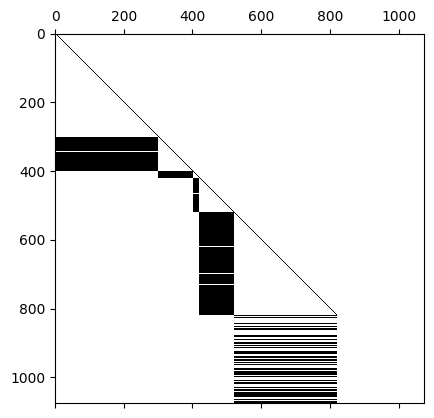

In [37]:
# Jacobian for Z-step
plt.spy(J)
plt.show()

Trained model reconstruction results:


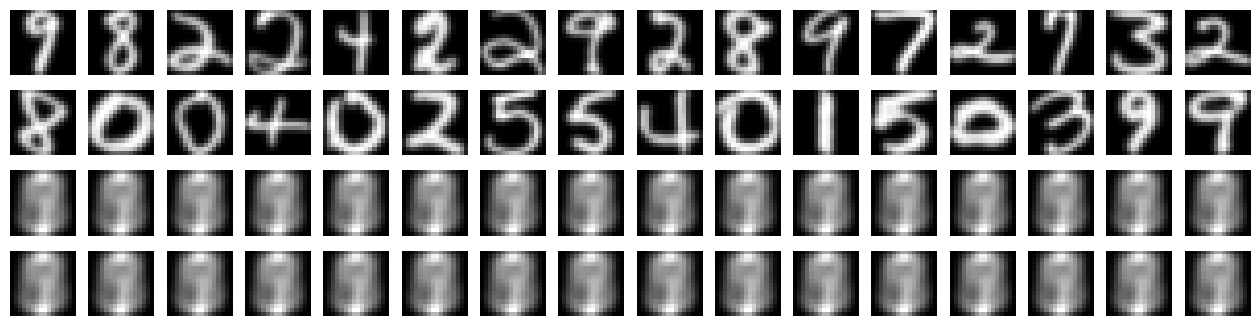

In [39]:
for x, _ in train_loader:
    x = x[:32].to(device)
    with torch.no_grad():
        z = model(x)
    
    print('Trained model reconstruction results:')
    plot_progress(x, z)
    
    break